In [1]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr,ttest_ind
from scipy.stats import sem

In [2]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if (0.001 < p < 0.01)|(p == 0.001):
        axs.text((x1+x2)*.5, y+h,  r"**", ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"***", ha='center', va='bottom', color=col, fontsize = 8)
    elif (0.01 < p < 0.05)|(p == 0.01):
        axs.text((x1+x2)*.5, y+h, r"*", ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"n.s.", ha='center', va='bottom', color=col, fontsize = 8)

# Load data

In [5]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [6]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

# Convert checkEnd to integer
data_choice_level["checkEnd"] = pd.to_numeric(data_choice_level["checkEnd"])
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1
data_choice_level['N_more'] = data_choice_level["currMas"] - data_choice_level["currNumCities"]
data_choice_level['scaled_N_more'] = data_choice_level.N_more/data_choice_level.currMas

bins = [np.nextafter(0, -1), np.nextafter(0, 1)] + list(np.linspace(1/9, 8/9, 8)) + [np.nextafter(1, 0), np.nextafter(1, 1)]
labels = ['0'] + [f'0.{i}' for i in range(1, 10)] + ['1']
# Bin the data
data_choice_level['scaled_N_more_bin'], cutoff_nmore = pd.cut(data_choice_level['scaled_N_more'], bins=bins, labels=labels, include_lowest=True, retbins=True)
data_choice_level['efficiency'] = (300-data_choice_level['leftover'])/data_choice_level['currNumCities']
data_choice_level['budget_change'] = abs(data_choice_level['budget_change'].values)
data_choice_level['within_reach_change'] = abs(data_choice_level['within_reach_change'].values)

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [12]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
# calculate context score
data_puzzle_level = data_puzzle_level.sort_values(["subjects","trialID"])
def calculate_rolling_mean(group):
    return group['numCities'].expanding().mean().shift(1)
data_puzzle_level['avg_numCities_before'] = data_puzzle_level.groupby('subjects').apply(calculate_rolling_mean).reset_index(level=0, drop=True)

In [13]:
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)

In [16]:
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['firstUndo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['firstUndo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [56]:
# select the data where undo is possible
def get_undo_data(df):
    # Use query method for cleaner condition checking
    condition = f"(submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index
    undo_data = df.loc[index + 1, ["subjects","puzzleID", "firstUndo",'lastUndo', "undo", "allMAS", "currMas","RT"]] 
    # Direct assignment from the same dataframe using .loc to avoid chaining
    columns_to_copy = ["currNumCities", "N_more", "severityOfErrors", "move_missed_reward", 
                       "error", "cumulative_error", "state_missed_reward", "checkEnd", "leftover", "budget_change", "within_reach_change", "efficiency", "within_reach"]
    for column in columns_to_copy:
        undo_data[column] = df.loc[index, column].values
    undo_data['sequential_undo'] = (undo_data.firstUndo != undo_data.lastUndo)&(undo_data.firstUndo == 1)
    undo_data['single_undo'] = (undo_data.firstUndo == undo_data.lastUndo)&(undo_data.firstUndo == 1)

    undo_data['terminal_undo'] = (undo_data.firstUndo == 1)&(undo_data.checkEnd == 1)
    undo_data['nonterminal_undo'] = (undo_data.firstUndo == 1)&(undo_data.checkEnd == 0)
    undo_data["suboptimal_state"] = undo_data["cumulative_error"]>0

    temp, cutoff_budget = pd.cut(undo_data['leftover'], 10 , labels = False, retbins=True)
    undo_data["leftover_bin"] = temp
    temp, cutoff_budgetchange = pd.cut(undo_data['budget_change'], 10 , labels = False, retbins=True)
    undo_data["budget_change_bin"] = temp
    temp, cutoff_withinreachchange = pd.cut(undo_data['within_reach_change'], 10 , labels = False, retbins=True, duplicates='drop')
    undo_data["within_reach_change_bin"] = temp
    temp, cutoff_efficiency = pd.cut(undo_data['efficiency'], 10 , labels = False, retbins=True, duplicates='drop')
    undo_data["efficiency_bin"] = temp

    return undo_data, np.around(cutoff_budget, 1), np.around(cutoff_budgetchange, 1), np.around(cutoff_withinreachchange, 1), np.around(cutoff_efficiency, 1)

undo_data, cutoff_budget, cutoff_budgetchange, cutoff_withinreachchange, cutoff_efficiency= get_undo_data(sc_data_choice_level)
undo_data = undo_data.merge(single_condition_data[["subjects","puzzleID", "RT1", "RT_branching", "RTsubmit"]], on=["subjects","puzzleID"], how = "left")
undo_data = undo_data.merge(puzzleID_order_data.loc[puzzleID_order_data.condition==0, ["subjects","puzzleID", "TT"]], on=["subjects","puzzleID"], how = "left")
only_undo_df = undo_data.loc[(undo_data.single_undo == 1)|(undo_data.sequential_undo == 1)] # for calculating proportions of different types of undo

In [57]:
%%R -i undo_data,data_dir

standardize <- function(x) {
    return (x - min(x))/(max(x) - min(x))
}
undo_data$subjects <- as.factor(undo_data[,"subjects"])
undo_data$puzzleID <- as.factor(undo_data[,"puzzleID"])
undo_data$checkEnd <- as.factor(undo_data[,"checkEnd"])
# undo_data$efficiency_new <- undo_data[,"efficiency"]^(0.3)
undo_data$N_more_new <- scale(undo_data[,"N_more"])
undo_data$currNumCities_new <- scale(undo_data[,"currNumCities"])
undo_data$leftover_new <- scale(undo_data[,"leftover"])
undo_data$leftover_currNumCities <- undo_data[,"currNumCities_new"]+undo_data[,"leftover_new"]
undo_data$within_reach_new <- scale(sqrt(undo_data[,"within_reach"]))
undo_data$budget_change_new <- scale(undo_data[,"budget_change"])
undo_data$within_reach_change_new <- scale(undo_data[,"within_reach_change"])

# save undo_data
write.csv(undo_data, file = paste0(data_dir, "statsdata_undo_data.csv"), row.names = F)

In [58]:
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

# Map characteristics - MAS (supp)

## Puzzle MAS distribution

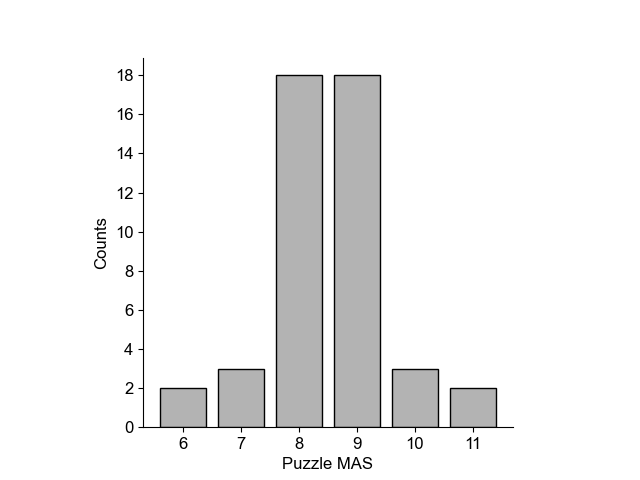

In [13]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

# Undo - Error

In [12]:
# Assuming sc_data_choice_level is your DataFrame
undo_noerror = undo_data.loc[undo_data.cumulative_error == 0, :]
undo_error = undo_data.loc[undo_data.cumulative_error != 0, :]
undo_noerror_avg = undo_noerror.groupby("subjects")['firstUndo'].mean()
undo_error_avg = undo_error.groupby("subjects")['firstUndo'].mean()

print(len(undo_noerror_avg))
print(len(undo_error_avg))

move_undo_noerror = undo_data.loc[undo_data.severityOfErrors == 0, :]
move_undo_error = undo_data.loc[undo_data.severityOfErrors != 0, :]
move_undo_noerror_avg = move_undo_noerror.groupby("subjects")['firstUndo'].mean()
move_undo_error_avg = move_undo_error.groupby("subjects")['firstUndo'].mean()
print(len(move_undo_noerror_avg))
print(len(move_undo_error_avg))

100
100
100
100


## Binary error

### state/move Hit/falsealarm/balancedaccuracy 

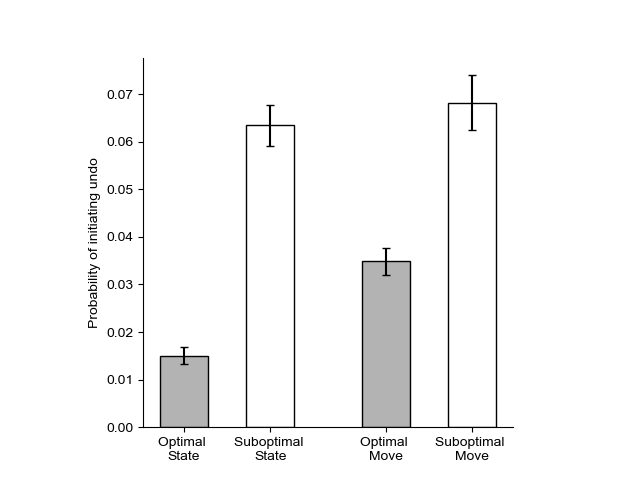

In [13]:
# This uses all undo
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# box plot
# bx = axs.boxplot([undo_noerror_avg, undo_error_avg,
#              move_undo_noerror_avg, move_undo_error_avg],
#                 widths=0.5,
#                 positions =[1,1.9,3.1,4],
#                 patch_artist=True,
#                 showfliers=False,
#                 boxprops=dict(color='k'),
#                 whiskerprops=dict(color='k'),
#                 capprops=dict(color='k'),
#                 medianprops=dict(color='k'))

# colors = [(.7,.7,.7),'w',(.7,.7,.7),'w']
# for patch, color in zip(bx['boxes'], colors):
#     patch.set_facecolor(color)
positions = [1, 1.9, 3.1, 4]

mean_values = [undo_noerror_avg.mean(), undo_error_avg.mean(), move_undo_noerror_avg.mean(), move_undo_error_avg.mean()]

bars = axs.bar(positions,
               mean_values,
               width=0.5,
               color=[(.7, .7, .7), 'w', (.7, .7, .7), 'w'],
               edgecolor='k')

# add standard error
errs = axs.errorbar(positions,
                    mean_values,
                    yerr=[undo_noerror_avg.sem(), undo_error_avg.sem(), move_undo_noerror_avg.sem(), move_undo_error_avg.sem()],
                    fmt='none',  # No connecting line
                    capsize=3,  # Cap size for error bar
                    ecolor='k')  # Error bar color

axs.set_ylabel('Probability of initiating undo')
axs.set_xticks([1,1.9,3.1,4])
axs.set_xticklabels(labels = ['Optimal \nState',
                              'Suboptimal \nState',
                              'Optimal \nMove',
                              'Suboptimal \nMove'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_all_type.png', dpi=300, bbox_inches='tight')

##### statistics

In [14]:
#--------------------------------------
y_offset = 0.01
h = 0.001
# run 2-independent-sample t test
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
print(stat1, p1)
x1, x2 = positions[0:2]
y, col = max(mean_values[0:2]) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

#--------------------------------------
stat3, p3 = wilcoxon(move_undo_noerror_avg, move_undo_error_avg, alternative = 'less')
print(stat3, p3 )
x1, x2 = positions[2:4]
y, col = max(mean_values[2:4]) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'undo_all_type.png', dpi=600, bbox_inches='tight')

5.0 1.0313151189296478e-16
573.0 1.4878867567008786e-09


### steps Hit/false alarm 

#### suboptimal state

##### terminal or not

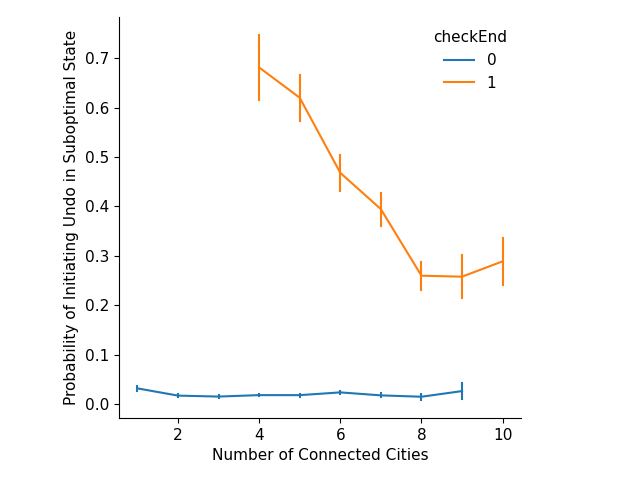

In [270]:
# This uses all undo
df_plot = undo_error.groupby(["subjects","checkEnd","currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
        #      color = "k",
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Suboptimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_error_step_terminal.png', dpi=300, bbox_inches='tight')

#### optimal state

##### allMAS

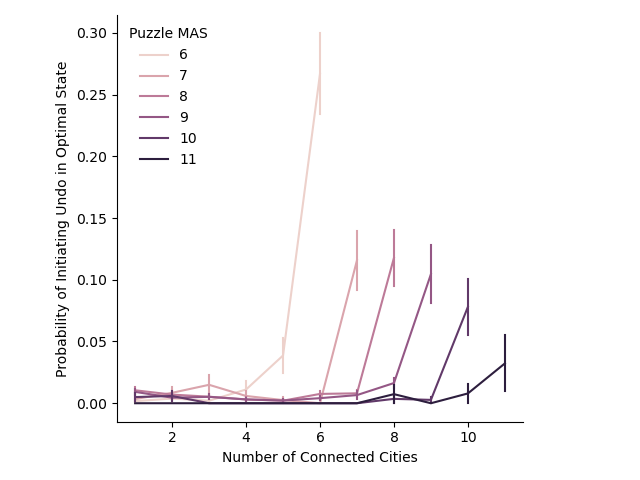

In [17]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["allMAS","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["allMAS","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

##### terminal or not

In [1]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","checkEnd", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

NameError: name 'undo_noerror' is not defined

### balanced accuracy correlation with basic condition

#### state-level

In [17]:
# This uses all undo
TNR = 1 - undo_noerror_avg # True Negative Rate 
balanced_accuracy = (undo_error_avg + TNR)/2

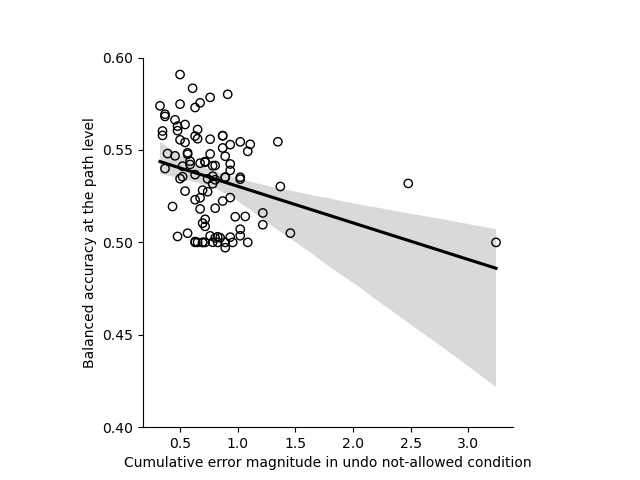

In [21]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy,               
             edgecolor="black",
                facecolor="None")
# add regplot line
sns.regplot(x=score, y=balanced_accuracy, ax=axs, ci=95, scatter=False, color='black')

# set yticks
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy at the path level') #Difference in undo initiation probability \nbetween optimal and suboptimal paths

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'path_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [22]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy)

SpearmanrResult(correlation=-0.38182817993772894, pvalue=8.85945768963304e-05)

#### move-level

In [18]:
move_TNR = 1 - move_undo_noerror_avg # True Negative Rate 
balanced_accuracy_move = (move_undo_error_avg + move_TNR)/2

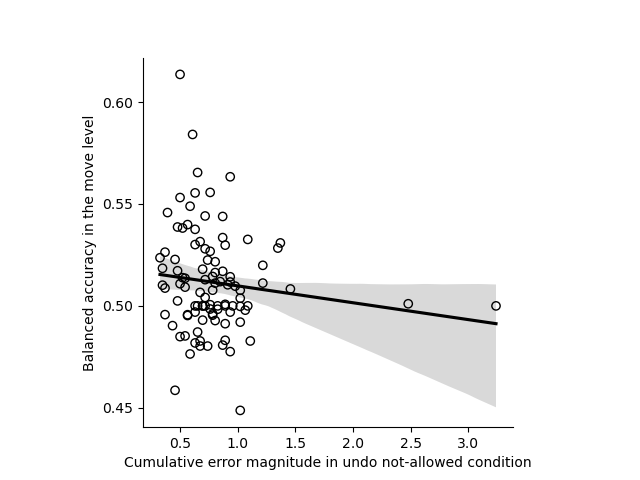

In [24]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy_move,               
             edgecolor="black",
             facecolor="None")
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

# add regplot line
sns.regplot(x=score, y=balanced_accuracy_move, ax=axs, ci=95, scatter=False, color='black')

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy in the move level') # Difference in undo initiation probability \nbetween optimal and suboptimal moves

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'move_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [25]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy_move)

SpearmanrResult(correlation=-0.13378809589916837, pvalue=0.18449713269822837)

## Error magnitude

### state-level error

#### Probability, all

In [14]:
undo_data_avg = undo_data.groupby(["subjects","cumulative_error"])["firstUndo"].mean().reset_index()
undo_data_avg.groupby(["cumulative_error"])["firstUndo"].count()

cumulative_error
0    100
1    100
2    100
3     81
4     42
5      8
6      3
8      1
Name: firstUndo, dtype: int64

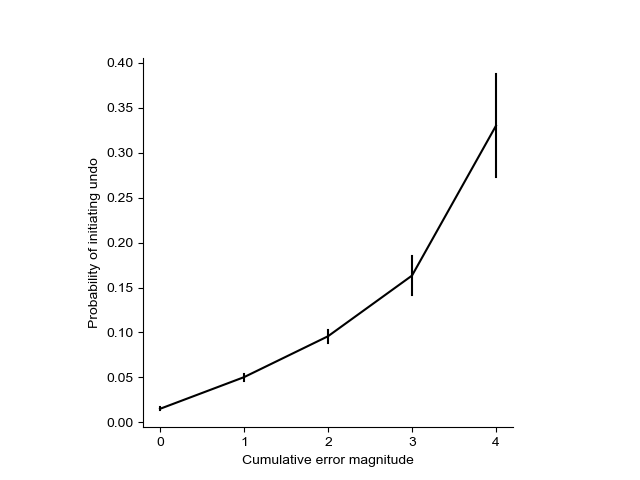

In [15]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='firstUndo', 
             data = undo_data_avg[undo_data_avg.cumulative_error<=4],
             color = 'k',
             err_style = "bars",
             errorbar = "se")

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)
axs.set(xlabel='Cumulative error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_cumulative_error_magnitude.png', dpi=300, bbox_inches='tight')

In [26]:
undo_data_avg = undo_data.groupby(["subjects","state_missed_reward"])["firstUndo"].mean().reset_index()
undo_data_avg.groupby(["state_missed_reward"])["firstUndo"].count()

state_missed_reward
0      100
22      63
26      97
30     100
34     100
38      91
40      26
42      80
48      64
54       5
56      93
64      99
66      24
72      44
78      55
80      34
90      60
96      27
102     15
110      4
112     20
114     27
128      3
130      3
144     10
150      2
170      1
192      1
224      1
Name: firstUndo, dtype: int64

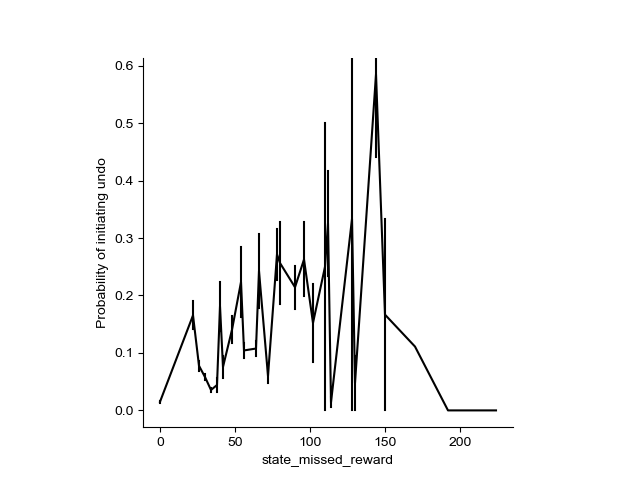

In [25]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='state_missed_reward', y='firstUndo', 
             data = undo_data_avg,
             color = 'k',
             err_style = "bars",
             errorbar = "se")

# axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)
axs.set(xlabel='state_missed_reward', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_state_missed_reward.png', dpi=300, bbox_inches='tight')

##### statistics

In [16]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error  + (1 |subjects) + (1|puzzleID),
                                  data = undo_data, family = "binomial")
# save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error + (1 | subjects) + (1 | puzzleID)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 19323.6  19359.4  -9657.8  19315.6    57529 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3566 -0.2349 -0.1738 -0.1130 15.5720 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.1610   1.077   
 puzzleID (Intercept) 0.1584   0.398   
Number of obs: 57533, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -4.43763    0.13303  -33.36   <2e-16 ***
cumulative_error  0.86953    0.02316   37.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cumultv_rrr -0.211


#### Probability, terminal or non-terminal

In [34]:
undo_data_end_avg = undo_data.groupby(["subjects","cumulative_error", "checkEnd"])["firstUndo"].mean().reset_index()
undo_data_end_avg.groupby(["cumulative_error", "checkEnd"])["firstUndo"].count()

cumulative_error  checkEnd
0                 0           100
                  1            99
1                 0           100
                  1            99
2                 0           100
                  1           100
3                 0            78
                  1            79
4                 0            37
                  1            37
5                 0             7
                  1             7
6                 0             3
                  1             1
8                 1             1
Name: firstUndo, dtype: int64

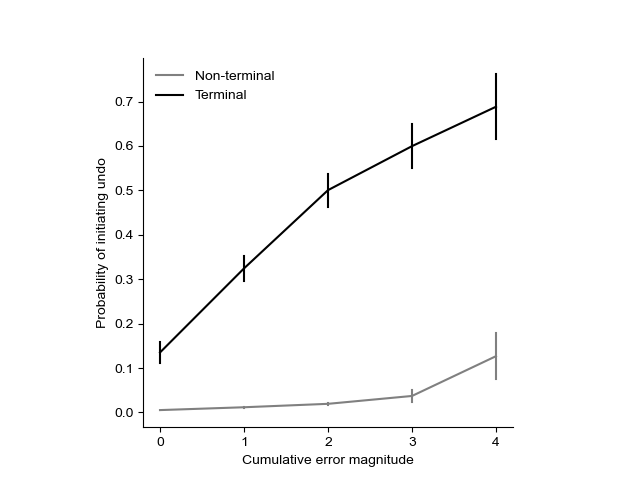

In [36]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='firstUndo', 
             data = undo_data_end_avg[undo_data_end_avg.cumulative_error<5], 
             hue = "checkEnd",
             palette = ["grey","k"],
             err_style = "bars",
             errorbar = "se")

plt.legend(labels=['Non-terminal','Terminal'], loc='upper left')

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_terminal_cumulative_error.png', dpi=300, bbox_inches='tight')

##### statistics

In [48]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error*checkEnd  + (1 |subjects),
                                  data = undo_data, family = "binomial")
save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error_checkEnd.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error * checkEnd + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 11328.3  11372.1  -5659.2  11318.3    47225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-9.503 -0.145 -0.092 -0.044 51.363 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.687    1.92    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -6.01574    0.20912  -28.77   <2e-16 ***
cumulative_error           0.66099    0.04337   15.24   <2e-16 ***
checkEnd                   3.30307    0.07644   43.21   <2e-16 ***
cumulative_error:checkEnd  0.61875    0.06140   10.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            

### move-level error

#### Probability, terminal or non-terminal

In [51]:
allUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['firstUndo'].mean().reset_index()
nonterminalUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['nonterminal_undo'].mean().reset_index()
terminalUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['terminal_undo'].mean().reset_index()
print(allUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())

   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        65
4                 4        22
5                 5         3
6                 6         3


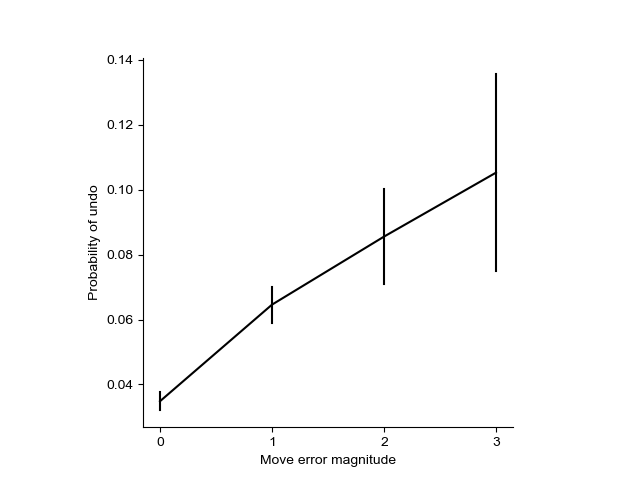

In [55]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='firstUndo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=3], 
             color = 'k', #
             err_style = "bars",
             errorbar = "se")
# sns.lineplot(x='severityOfErrors', y='nonterminal_undo',
#              data = nonterminalUndo_sub[nonterminalUndo_sub.severityOfErrors<=3],
#              color = '#fc8d62',
#              err_style = "bars",
#              errorbar = "se")
# sns.lineplot(x='severityOfErrors', y='terminal_undo',
#                 data = terminalUndo_sub[terminalUndo_sub.severityOfErrors<=3],
#                 color = '#8da0cb',
#                 err_style = "bars",
#                 errorbar = "se")

# add manual legend
# plt.legend(labels=['All undo','Non-terminal undo','Terminal undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Move error magnitude', ylabel='Probability of undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_error_magnitude.png', dpi=300, bbox_inches='tight')

In [27]:
allUndo_sub = undo_data.groupby(['subjects','state_missed_reward'])['firstUndo'].mean().reset_index()
print(allUndo_sub.groupby(['state_missed_reward'])['subjects'].count().reset_index())

    state_missed_reward  subjects
0                     0       100
1                    22        63
2                    26        97
3                    30       100
4                    34       100
5                    38        91
6                    40        26
7                    42        80
8                    48        64
9                    54         5
10                   56        93
11                   64        99
12                   66        24
13                   72        44
14                   78        55
15                   80        34
16                   90        60
17                   96        27
18                  102        15
19                  110         4
20                  112        20
21                  114        27
22                  128         3
23                  130         3
24                  144        10
25                  150         2
26                  170         1
27                  192         1
28            

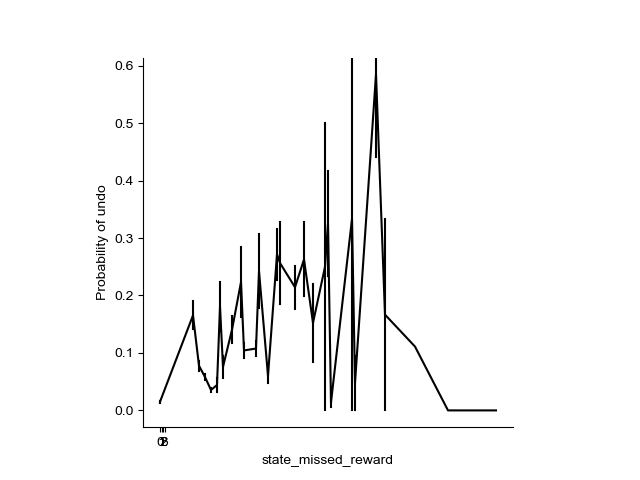

In [28]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='state_missed_reward', y='firstUndo', 
             data = allUndo_sub, 
             color = 'k', #
             err_style = "bars",
             errorbar = "se")

axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)

axs.set(xlabel='state_missed_reward', ylabel='Probability of undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_state_missed_reward.png', dpi=300, bbox_inches='tight')

##### statistics

In [19]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + severityOfErrors  + (1 |subjects) + (1|puzzleID),
                                  data = undo_data, family = "binomial")
# save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_error_magnitude.RData", sep="")))
print(summary(model_undo))

# model_undo = lme4::glmer(sequential_undo ~  1 + severityOfErrors + (1 |subjects),
#                                   data = undo_data, family = "binomial")
# save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_sequential_undo_error_magnitude.RData", sep="")))
# print(summary(model_undo))

# model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
#                                   data = undo_data, family = "binomial")
# save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_single_undo_error_magnitude.RData", sep="")))
# print(summary(model_undo))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + severityOfErrors + (1 | subjects) + (1 | puzzleID)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 20581.1  20617.0 -10286.6  20573.1    57529 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8776 -0.2549 -0.2044 -0.1407 14.1391 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.02056  1.0102  
 puzzleID (Intercept) 0.07679  0.2771  
Number of obs: 57533, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -3.7142     0.1174 -31.635   <2e-16 ***
severityOfErrors   0.4251     0.0428   9.933   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.070


#### Proportion, sequential or single, mapMAS

In [64]:
singleUndo_sub = only_undo_df.groupby(['subjects','severityOfErrors','allMAS'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors','allMAS'])['subjects'].count().reset_index()

,severityOfErrors,allMAS,subjects
0,0,6,56
1,0,7,64
2,0,8,82
3,0,9,78
4,0,10,40
5,0,11,39
6,1,6,12
7,1,7,20
8,1,8,48
9,1,9,56


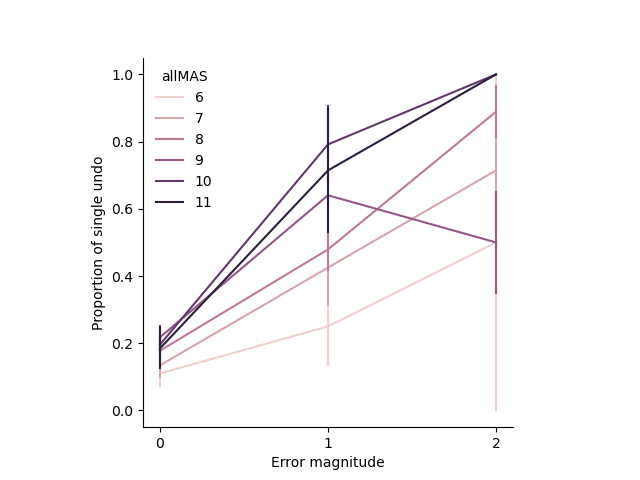

In [63]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='single_undo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             hue = "allMAS",
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
# for i in range(len(n_sub)):
#     # add text to lineplot
#     lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
#                   y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
#                   s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
#                   color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'prop_single_error_magnitude.png', dpi=300, bbox_inches='tight')

In [65]:
%%R -i only_undo_df,out_dir2
only_undo_df$subjects <- as.factor(only_undo_df[,"subjects"])

# lambda = 0.33
# error_undo_df$severityOfErrors_lamda <- (error_undo_df$severityOfErrors^lambda-1)/lambda
model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = only_undo_df, family = "binomial")

save(model_undo, only_undo_df, file=file.path(out_dir2, file=paste("model_prop_single_undo_error_magnitude.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: only_undo_df

     AIC      BIC   logLik deviance df.resid 
  2076.2   2093.8  -1035.1   2070.2     2657 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.5690  -0.3739  -0.3001  -0.2164   5.1250 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.981    1.407   
Number of obs: 2660, groups:  subjects, 90

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.7879     0.1756  -10.18   <2e-16 ***
severityOfErrors   1.7452     0.1272   13.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.198


# Undo - state features

## number of cities

#### optimality, only terminal

In [92]:
firstUndo_sub = undo_data[undo_data.checkEnd==1].groupby(['subjects','currNumCities','suboptimal_state'])['undo'].mean().reset_index()
# firstUndo_sub.groupby(['currNumCities','error'])['firstUndo'].count()

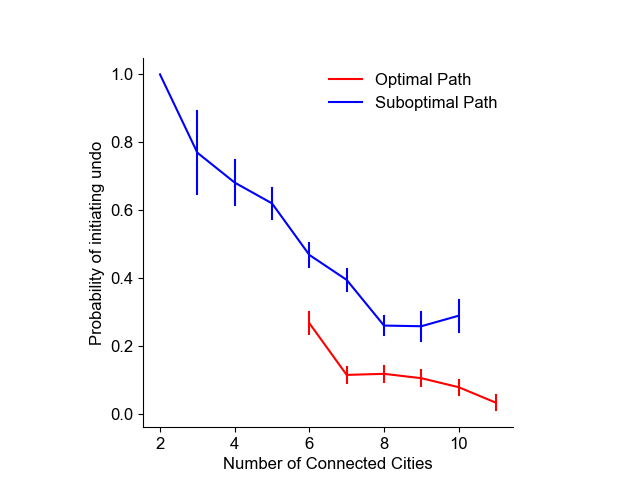

In [93]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             data = firstUndo_sub,
             hue = 'suboptimal_state',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Optimal Path','Suboptimal Path'], loc='upper right')
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
# fig.savefig(out_dir+'undo_currNumCities.png', dpi=300, bbox_inches='tight')
plt.show()

### terminal 

In [95]:
firstUndo_sub = undo_data.groupby(['subjects','currNumCities',"checkEnd"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["currNumCities","checkEnd"])['firstUndo'].count().reset_index()
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

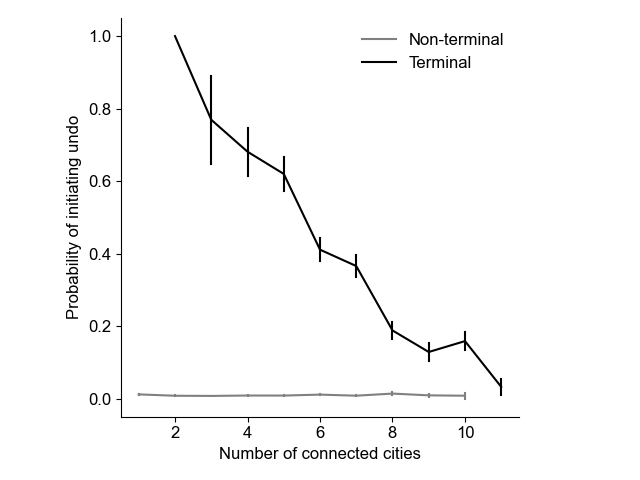

In [98]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             hue = "checkEnd", 
             data = firstUndo_sub,
             errorbar = "se",
             err_style = "bars",
             palette = ['grey','k']
             )
axs.set(xlabel='Number of connected cities', 
        ylabel='Probability of initiating undo')
# set legend title
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_step_terminal.png', dpi=300, bbox_inches='tight')

### Across N_more

In [37]:
firstUndo_sub = undo_data.groupby(['subjects','N_more'])['firstUndo'].mean().reset_index()

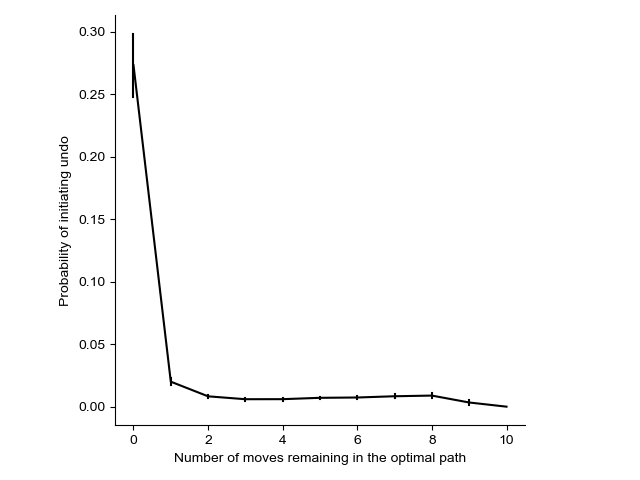

In [40]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='N_more', y='firstUndo', 
        #      hue = "allMAS", 
             color = 'k',
             data = firstUndo_sub,
             errorbar = "se",
             err_style = "bars"
             #palette = ['red','blue']
             )
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of moves remaining in the optimal path', 
        ylabel='Probability of initiating undo')
# set legend title
# axs.legend(title = "Puzzle MAS", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_nmore.png', dpi=300, bbox_inches='tight')

### Puzzle MAS

In [44]:
firstUndo_sub = undo_data.groupby(['subjects','allMAS','checkEnd'])['firstUndo'].mean().reset_index()
# firstUndo_sub.groupby(['allMAS','checkEnd'])['firstUndo'].count()

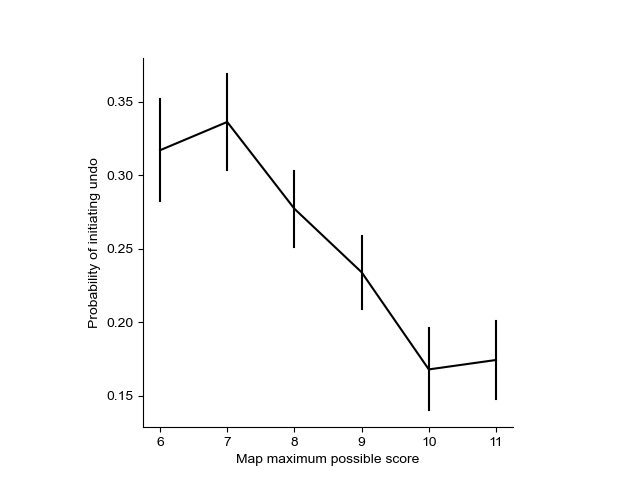

In [46]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.checkEnd==1], 
             hue = 'checkEnd',
             palette = ['k'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# hide legend
axs.get_legend().remove()
axs.set(xlabel='Map maximum possible score', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_MAS.png', dpi=300, bbox_inches='tight')
plt.show()

### proportion, sequential undo - terminal/non-terminal

In [21]:
sequentialUndo_sub = only_undo_df.groupby(['subjects','checkEnd'])['sequential_undo'].mean().reset_index()

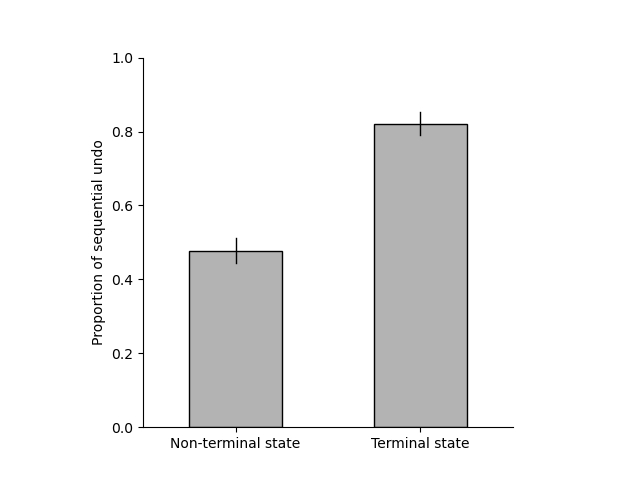

In [22]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequential_undo', 
            data = sequentialUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18

# # add text on the upper of each bar 
# for x, y, n in zip([0,1], sequentialUndo_sub.groupby(['checkEnd'])['sequential_undo'].mean(), n_sub.sequentialUndo):
#     axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'sequential_terminal.png', dpi=300, bbox_inches='tight')

In [23]:
stat1, p1 = mannwhitneyu(np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequential_undo']), 
                     np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequential_undo'])) 
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
print(stat1, p1)

5423.0 2.194581026983643e-12


## Remaining budget

In [105]:
firstUndo_sub = undo_data.groupby(['subjects','leftover_bin', 'checkEnd'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['leftover_bin', 'checkEnd'])['firstUndo'].count()
# firstUndo_sub = firstUndo_sub.merge(count_df, on = ["leftover_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

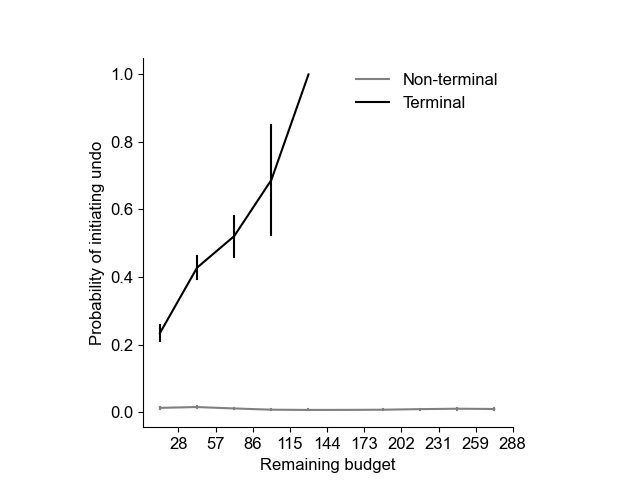

In [106]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'checkEnd',
             palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 10.5, 1))
axs.set_xticklabels(cutoff_budget[1:].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budget.png', dpi=300, bbox_inches='tight')
plt.show()

## Efficiency

## Budget change

In [30]:
firstUndo_sub = undo_data.groupby(['subjects','budget_change_bin', 'N_more'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['budget_change_bin', 'N_more'])['firstUndo'].count()
# firstUndo_sub = firstUndo_sub.merge(count_df, on = ["budget_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

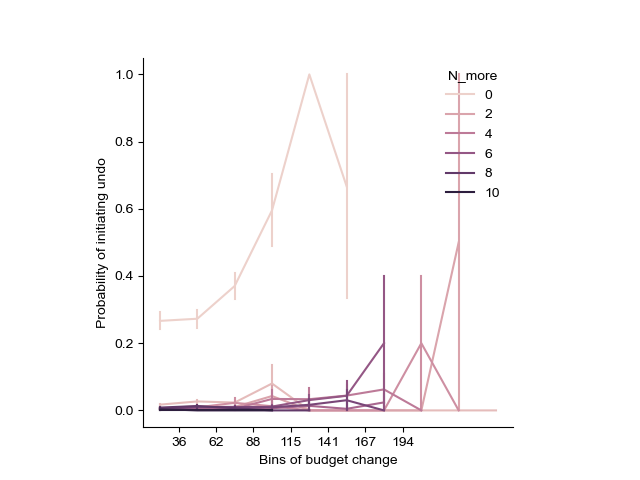

In [33]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'N_more',
            #  palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 7.5, 1))
axs.set_xticklabels(cutoff_budgetchange[1:8].astype(int))
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Bins of budget change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

## Within reach change

In [112]:
# plot undo across leftover_bin
firstUndo_sub = undo_data.groupby(['subjects','within_reach_change_bin','checkEnd'])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(['within_reach_change_bin', 'checkEnd'])['firstUndo'].count()
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["within_reach_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

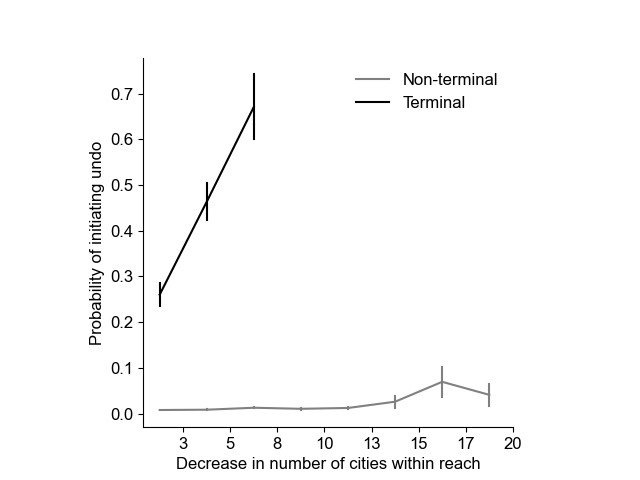

In [113]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='within_reach_change_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = "checkEnd",
             palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff_withinreachchange[1:9].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set(xlabel='Decrease in number of cities within reach', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_withinreach_change_terminal.png', dpi=300, bbox_inches='tight')

# Errors

In [59]:
# error as a state instead of a type of move
def get_error_data(df):
    condition = f"(submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index

    undo_data = df.loc[index, ["subjects","puzzleID","error","severityOfErrors", "cumulative_error","undo","allMAS","currNumCities","N_more", "checkEnd",'leftover', "within_reach",'budget_change', 'within_reach_change', "currNos"]]
    undo_data = undo_data.loc[undo_data.undo != 1,:] # restrict actions to only moves
    temp, cutoff_budget = pd.cut(undo_data['leftover'], 10 , labels = False, retbins=True, precision = 1)
    undo_data["leftover_bin"] = temp
    temp, cutoff_budgetchange = pd.cut(undo_data['budget_change'], 10 , labels = False, retbins=True, precision = 1)
    undo_data["budget_change_bin"] = temp
    temp, cutoff_withinreachchange = pd.cut(undo_data['within_reach_change'], 10 , labels = False, retbins=True, precision = 1, duplicates='drop')
    undo_data["within_reach_change_bin"] = temp
    return undo_data, np.around(cutoff_budget, 1), np.around(cutoff_budgetchange, 1), np.around(cutoff_withinreachchange, 1)

data_cond0_outcome, _,_,_ = get_error_data(data_choice_level[(data_choice_level['condition']==0)])
data_cond1_outcome, cutoff_budget,cutoff_budgetchange,cutoff_withinreachchange = get_error_data(sc_data_choice_level)

data_cond1_outcome = data_cond1_outcome.merge(single_condition_data[["subjects","puzzleID", "action_gap", "RT1", "RT_branching", "RTsubmit", "numFullUndo"]], on=["subjects","puzzleID"], how = "left")

In [60]:
selected_index = (data_cond1_outcome.currNumCities==1)&(data_cond1_outcome.undo==0)
selected_df = data_cond1_outcome.loc[selected_index,:]
selected_df['undo_used'] = selected_df['numFullUndo'] > 0
avg = selected_df.groupby(['subjects','undo_used'])['cumulative_error'].mean().groupby('undo_used').mean()
print(selected_df.groupby(['subjects','undo_used'])['action_gap'].mean().groupby('undo_used').mean())

selected_index = (data_cond0_outcome.currNumCities==1)
selected_df2 = data_cond0_outcome.loc[selected_index,:]
selected_df2 = selected_df2.merge(selected_df[["subjects","puzzleID", "undo_used"]], on=["subjects","puzzleID"], how = "left")
avg2 = selected_df2.groupby(['subjects','undo_used'])['cumulative_error'].mean().groupby('undo_used').mean()

print(avg)
print(avg2)


undo_used
False    3.827102
True     3.679251
Name: action_gap, dtype: float64
undo_used
False    0.374031
True     0.425917
Name: cumulative_error, dtype: float64
undo_used
False    0.393213
True     0.356914
Name: cumulative_error, dtype: float64


/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_19344/474422640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['undo_used'] = selected_df['numFullUndo'] > 0


In [62]:
%%R -i selected_df,single_condition_data
selected_df$subjects <- as.factor(selected_df[,"subjects"])
selected_df$puzzleID <- as.factor(selected_df[,"puzzleID"])

single_condition_data$subjects <- as.factor(single_condition_data[,"subjects"])
single_condition_data$puzzleID <- as.factor(single_condition_data[,"puzzleID"])

# model_error = lme4::glmer(severityOfErrors ~  1 + action_gap + (1 |subjects),
#                                   data = selected_df, family = "poisson")
model_error = lme4::glmer(error ~  1 + action_gap + (1 |subjects),
                                  data = selected_df, family = "binomial")
# model_undo = lme4::glmer(numFullUndo ~  1 + action_gap + (1 |subjects) + (1|puzzleID),
#                                     data = single_condition_data, family = "poisson")
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + action_gap + (1 | subjects)
   Data: selected_df

     AIC      BIC   logLik deviance df.resid 
  6880.4   6900.4  -3437.2   6874.4     5802 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4584 -0.6634 -0.5410  1.1252  2.7175 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1075   0.3279  
Number of obs: 5805, groups:  subjects, 100

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.38205    0.18686  -18.10   <2e-16 ***
action_gap   0.66792    0.04728   14.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
action_gap -0.971


In [16]:
%%R -i data_cond0_outcome,data_cond1_outcome,out_dir2
data_cond0_outcome$subjects <- as.factor(data_cond0_outcome[,"subjects"])
data_cond0_outcome$allMAS <- as.factor(data_cond0_outcome[,"allMAS"])
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$allMAS <- as.factor(data_cond1_outcome[,"allMAS"])

data_cond1_outcome$currNumCities_new <- scale(data_cond1_outcome[,"currNumCities"])
data_cond1_outcome$leftover_new <- scale(data_cond1_outcome[,"leftover"])
data_cond1_outcome$within_reach_new <- scale(sqrt(data_cond1_outcome[,"within_reach"]))
data_cond1_outcome$budget_change_new <- scale(data_cond1_outcome[,"budget_change"])
data_cond1_outcome$within_reach_change_new <- scale(data_cond1_outcome[,"within_reach_change"])

# save undo_data
write.csv(data_cond1_outcome, file = paste0(data_dir, "error_data_undo_condition.csv"), row.names = F)

## number of cities

### Basic condition (supp)

In [93]:
error_sub = data_cond0_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
# error_sub.groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

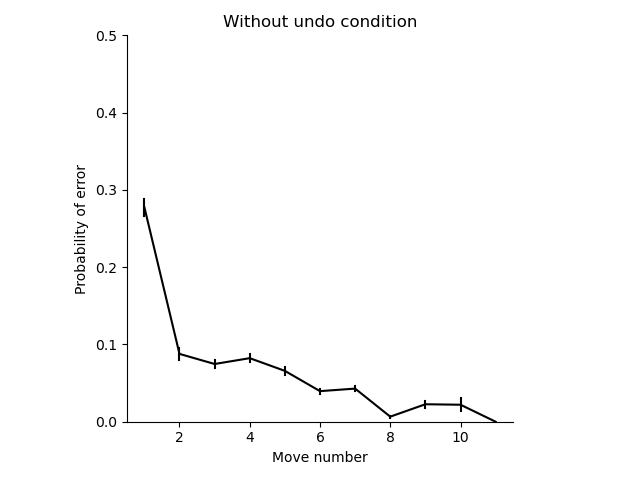

In [94]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, 
             errorbar = "se",
             err_style = "bars")
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
# axs.legend(title = "Puzzle MAS", 
            #   frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_basic_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [ ]:
%%R -i
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond0_outcome, family = "binomial")
save(model_error, data_cond0_outcome, file=file.path(out_dir2, file=paste("model_error_step_basic_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond0_outcome[(data_cond0_outcome$allMAS == 8) | (data_cond0_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14572.4  14605.3  -7282.2  14564.4    27387 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0427 -0.3540 -0.2325 -0.1478  8.7125 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1166   0.3415  
Number of obs: 27391, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42462    0.05214  -27.32  < 2e-16 ***
prevNumCities -0.40420    0.01198  -33.73  < 2e-16 ***
allMAS9        0.16285    0.04450    3.66 0.000252 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

### Undo condition

#### cumulative error

In [84]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities','checkEnd'])['cumulative_error'].mean().reset_index()
count_df = error_sub.groupby(['currNumCities','checkEnd'])['cumulative_error'].count().reset_index()
# error_sub = error_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['cumulative_error_count'] > 30]

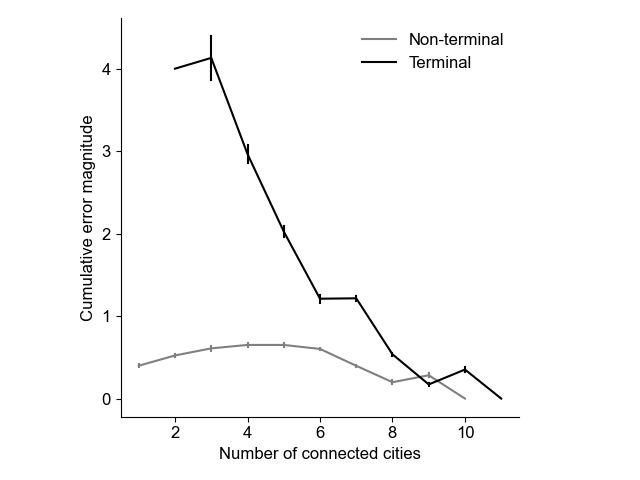

In [86]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='cumulative_error', 
             hue = "checkEnd", 
             data = error_sub, 
             errorbar = "se",
             err_style = "bars",
             palette = ['grey','k']
             )
axs.set(xlabel='Number of connected cities', ylabel='Cumulative error magnitude')
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'cumulative_error_step_undo_condition.png', dpi=300, bbox_inches='tight')

#### error magnitude

In [82]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['severityOfErrors'].mean().reset_index()
# count_df = error_sub.groupby(['currNumCities','checkEnd'])['severityOfErrors'].count().reset_index()
# error_sub = error_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['severityOfErrors_count'] > 30]

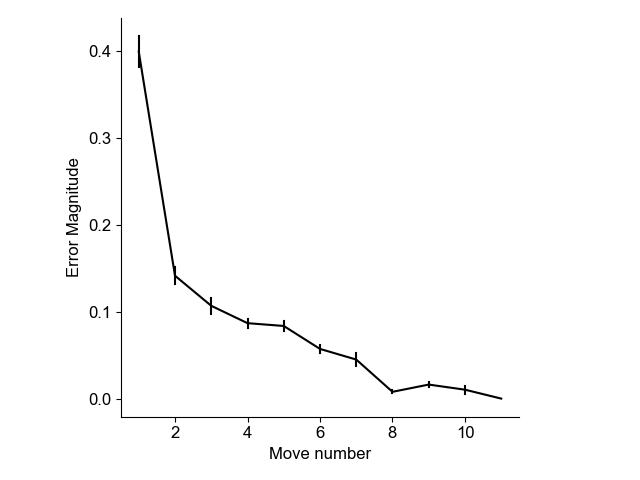

In [83]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='severityOfErrors', 
            #  hue = "checkEnd", 
             data = error_sub, 
             errorbar = "se",
             err_style = "bars",
             color = "k"
            #  palette = ['grey','k']
             )
axs.set(xlabel='Move number', ylabel='Error Magnitude')
# axs.set_ylim(0,0.5)
# axs.set_xticks([0,1,2,3,4,5,6,7,8])
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'severityOfErrors_step_undo_condition.png', dpi=300, bbox_inches='tight')

#### error

In [44]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()

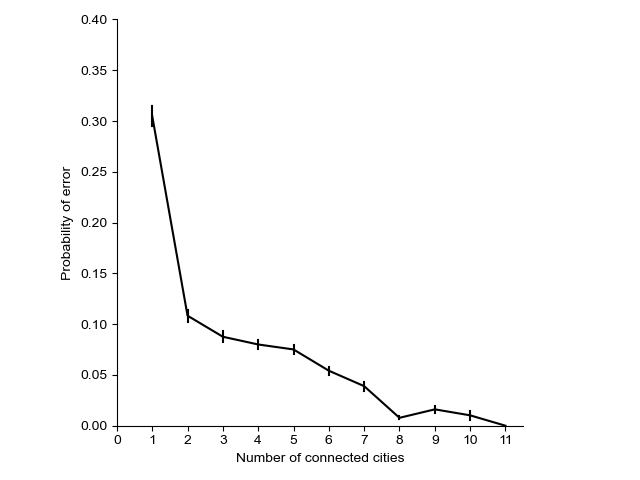

In [50]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, # .loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:]
             errorbar = "se",
             err_style = "bars",
            #  palette = ['red','blue']
             )
axs.set(xlabel='Number of connected cities', ylabel='Probability of error')
axs.set_ylim(0,0.4)
axs.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
# axs.legend(title = "Puzzle MAS", frameon=False)
# axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_undo_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [ ]:
%%R 
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond1_outcome, family = "binomial")
save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_error_step_undo_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + (1 | subjects)
   Data: data_cond1_outcome

     AIC      BIC   logLik deviance df.resid 
 27606.0  27632.9 -13800.0  27600.0    57530 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0524 -0.3217 -0.2063 -0.1301 16.1670 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.08051  0.2838  
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.196736   0.037219  -32.15   <2e-16 ***
prevNumCities -0.459808   0.008891  -51.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
prevNumCits -0.462


## Puzzle MAS

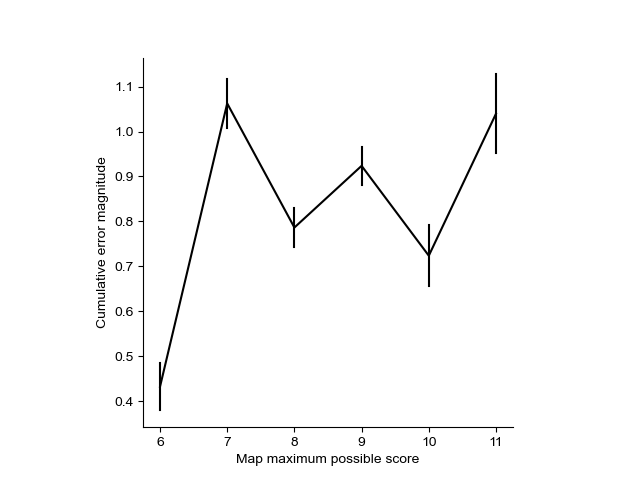

In [50]:
error_sub = data_cond1_outcome.groupby(['subjects','allMAS',"checkEnd"])['cumulative_error'].mean().reset_index()
error_sub.groupby(['allMAS',"checkEnd"])['cumulative_error'].count()
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='cumulative_error', 
             data = error_sub[error_sub.checkEnd==1],#
             hue = 'checkEnd',
             palette = ['k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
# axs.set_ylim(0,0.7)
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
axs.get_legend().remove()
axs.set(xlabel='Map maximum possible score', ylabel='Cumulative error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_mas.png', dpi=300, bbox_inches='tight')
plt.show()

## remaining budget

In [89]:
error_sub = data_cond1_outcome.groupby(['subjects','leftover_bin',"checkEnd"])['cumulative_error'].mean().reset_index()
count_df = error_sub.groupby(['leftover_bin', 'checkEnd'])['cumulative_error'].count()
# error_sub = error_sub.merge(count_df, on = ["leftover_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['cumulative_error_count'] > 30]

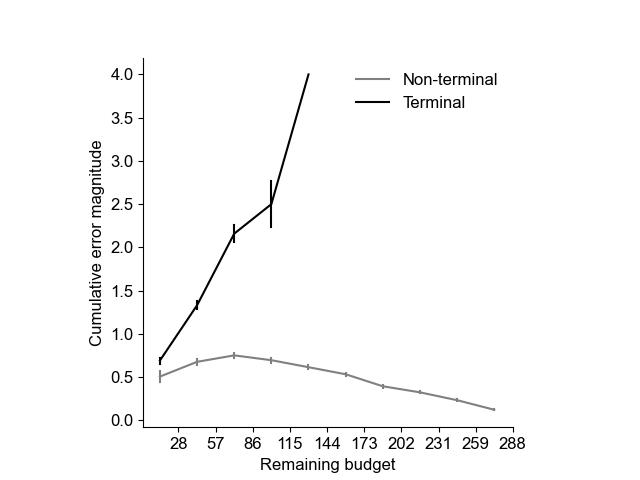

In [91]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='cumulative_error', 
             data = error_sub,
             hue = "checkEnd",
            #  color = 'k',
             palette = ['grey','k'],
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 10.5, 1))
axs.set_xticklabels(cutoff_budget[1:].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper right')
# axs.set_ylim(0,0.7)
axs.set(xlabel='Remaining budget', ylabel='Cumulative error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_leftover.png', dpi=300, bbox_inches='tight')
plt.show()

In [152]:
spearmanr(data_cond1_outcome.loc[data_cond1_outcome.checkEnd==1,'leftover'], data_cond1_outcome.loc[data_cond1_outcome.checkEnd==1,'currNumCities'])

SpearmanrResult(correlation=-0.1774339897378646, pvalue=1.7192765690344817e-46)

## Budget change

In [43]:
error_sub = data_cond1_outcome.groupby(['subjects','budget_change_bin', 'N_more'])['severityOfErrors'].mean().reset_index()
count_df = error_sub.groupby(['budget_change_bin', 'N_more'])['severityOfErrors'].count()
# error_sub = error_sub.merge(count_df, on = ["budget_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
# error_sub = error_sub[error_sub['severityOfErrors_count'] > 30]

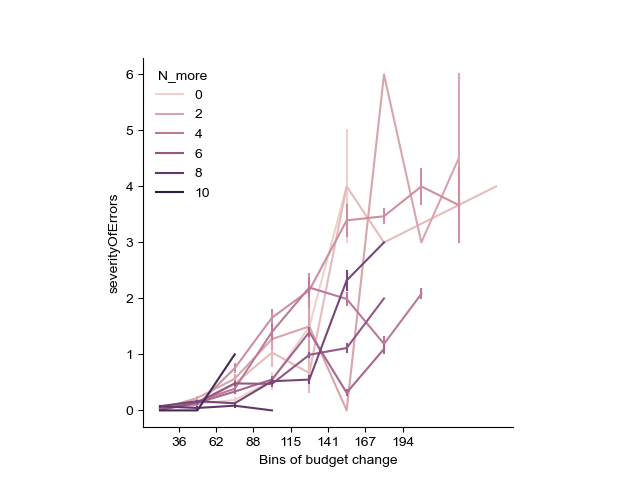

In [44]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='severityOfErrors', 
             hue = "N_more",
             data = error_sub,
            #  palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 7.5, 1))
axs.set_xticklabels(cutoff_budgetchange[1:8].astype(int))
# axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='lower right')
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of budget change', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

## Within reach change

In [114]:
# plot undo across leftover_bin
undo_error_sub = data_cond1_outcome.groupby(['subjects','within_reach_change_bin', "checkEnd"])['severityOfErrors'].mean().reset_index()
count_df = undo_error_sub.groupby(['within_reach_change_bin', 'checkEnd'])['severityOfErrors'].count()
undo_error_sub = undo_error_sub.merge(count_df, on = ["within_reach_change_bin","checkEnd"], how = "left", suffixes = ("","_count"))
undo_error_sub = undo_error_sub[undo_error_sub['severityOfErrors_count'] > 30]

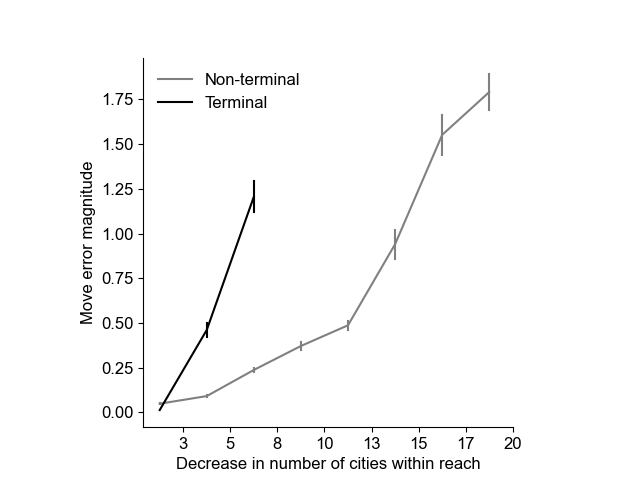

In [117]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='within_reach_change_bin', y='severityOfErrors', 
             data = undo_error_sub,
             hue = "checkEnd",
                palette = ['grey','k'],
            #  color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff_withinreachchange[1:9].astype(int))
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper left')
axs.set(xlabel='Decrease in number of cities within reach', ylabel='Move error magnitude')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'error_withinreachchange_terminal.png', dpi=300, bbox_inches='tight')

In [60]:
spearmanr(data_cond1_outcome.loc[data_cond1_outcome.checkEnd==0,'within_reach_change'], data_cond1_outcome.loc[data_cond1_outcome.checkEnd==0,'budget_change'])

SpearmanrResult(correlation=0.5227938426313945, pvalue=0.0)

# Uncertainty (First-move RT)

In [48]:
# for RT1 and RT_branching, use only the very first undo
def uncertainty_df_process(df, condition, firstUndo):
    index = df.query(condition).index
    df_beforeUndo = df.loc[index-1,:]
    index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)] 
    state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID',"cumulative_error", 'allMAS', 'currNumCities', "scaled_N_more_bin"]]

    state_undo_1undo = state_undo_1undo.merge(puzzleID_order_data.loc[puzzleID_order_data.condition==0, ["subjects","puzzleID", "RT1"]], on=["subjects","puzzleID"], how = "left")
    state_undo_1undo = state_undo_1undo.rename(columns = {"RT1":"RT1_basic"})
    state_undo_1undo = state_undo_1undo.merge(single_condition_data[["subjects","puzzleID", "RT1", "RT_branching", "avg_numCities_before"]], on=["subjects","puzzleID"], how = "left")
    state_undo_1undo["RT"] = list(df.loc[index_end_undo+1,'RT'])
    state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
    state_undo_1undo["RT1_basic_log"] = np.log(state_undo_1undo["RT1_basic"]+1)
    state_undo_1undo['firstUndo'] = firstUndo
    state_undo_1undo['error'] = state_undo_1undo['cumulative_error'] > 0
    state_undo_1undo['RPE'] = state_undo_1undo['currNumCities'] - state_undo_1undo['avg_numCities_before']
    return state_undo_1undo

state_undo_1undo = uncertainty_df_process(data_subset_before1undo, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(data_subset_before1undo, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1.astype(int)
temp2, cutoff = pd.cut(state_df_1undo['RT1_basic_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_basic_bin'] = temp2.astype(int)

##### rt1 - Map MAS

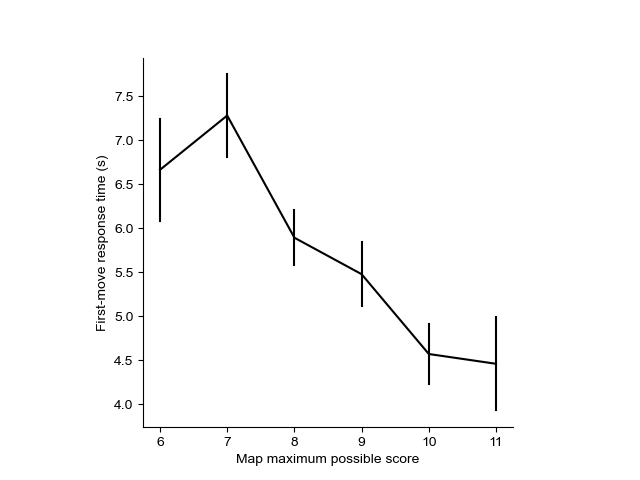

In [62]:
RT_sub = state_df_1undo.groupby(['subjects','allMAS'])['RT1_basic'].mean().reset_index()

fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='RT1_basic', 
             data = RT_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set(xlabel='Map maximum possible score', ylabel='First-move response time (s)')
axs.set_aspect(1/axs.get_data_ratio())

fig.savefig(out_dir+'rt_allMAS.png', dpi=300, bbox_inches='tight')
plt.show()

##### undo 

In [17]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin','error'])['firstUndo'].count()

rt1_bin  error
1        False    92
         True     92
2        False    97
         True     99
3        False    54
         True     66
4        False     8
         True     16
5        False     1
         True      4
Name: firstUndo, dtype: int64

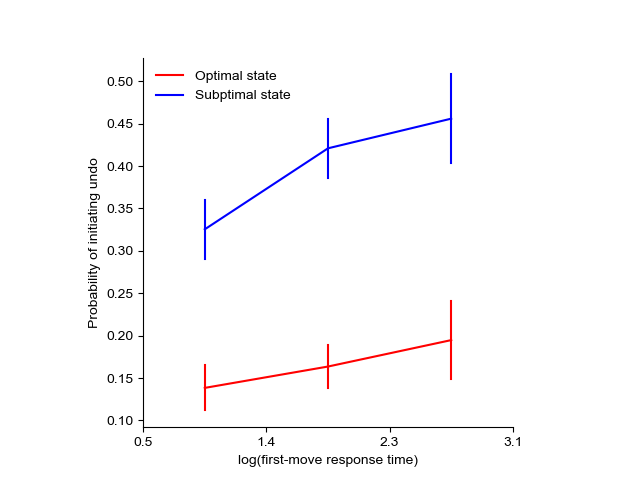

In [26]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             hue = "error",
             palette = ["r", "b"],
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
axs.legend(labels=['Optimal state','Subptimal state'], frameon=False, loc='upper left')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='log(first-move response time)', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_basic_bin','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_basic_bin','error'])['firstUndo'].count()

rt1_basic_bin  error
1              False     98
               True      97
2              False     96
               True     100
3              False     44
               True      52
4              False      9
               True       9
5              False      1
               True       5
Name: firstUndo, dtype: int64

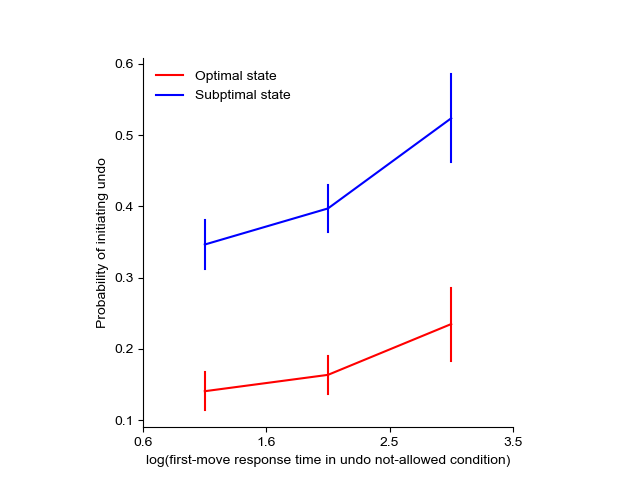

In [33]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_basic_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_basic_bin<=3],
             hue = "error",
             palette = ["r", "b"],
             err_style = "bars",
             errorbar = "se")

# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
axs.legend(labels=['Optimal state','Subptimal state'], frameon=False, loc='upper left')

# hide legend
# axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='log(first-move response time in undo not-allowed condition)', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_basic_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$error <- as.factor(state_df_1undo[,"error"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log*error + (1 |subjects),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log * error + (1 | subjects)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  3246.6   3278.3  -1618.3   3236.6     4152 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2821 -0.4000 -0.1540  0.0886  9.0715 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 5.956    2.44    
Number of obs: 4157, groups:  subjects, 100

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -3.1675     0.3721  -8.513  < 2e-16 ***
RT1_log             0.1789     0.1595   1.122    0.262    
errorTRUE           2.3168     0.3280   7.063 1.63e-12 ***
RT1_log:errorTRUE  -0.1776     0.1885  -0.942    0.346    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) RT1_lg erTRUE
RT1_log     -0.69

In [39]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + RT1_basic_log*error + (1 |subjects),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_basic_log * error + (1 | subjects)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  5526.8   5560.6  -2758.4   5516.8     6399 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8211 -0.4708 -0.1689  0.4296  8.8908 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 5.274    2.297   
Number of obs: 6404, groups:  subjects, 100

Fixed effects:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.57210    0.31488 -11.344   <2e-16 ***
RT1_basic_log            0.26055    0.10527   2.475   0.0133 *  
errorTRUE                2.23498    0.24484   9.128   <2e-16 ***
RT1_basic_log:errorTRUE  0.01895    0.12504   0.152   0.8796    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (I

##### error 

In [24]:
error_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['rt1_bin'])['cumulative_error'].count()

rt1_bin
1    98
2    99
3    74
4    22
5     4
Name: cumulative_error, dtype: int64

NameError: name 'cutoff_round' is not defined

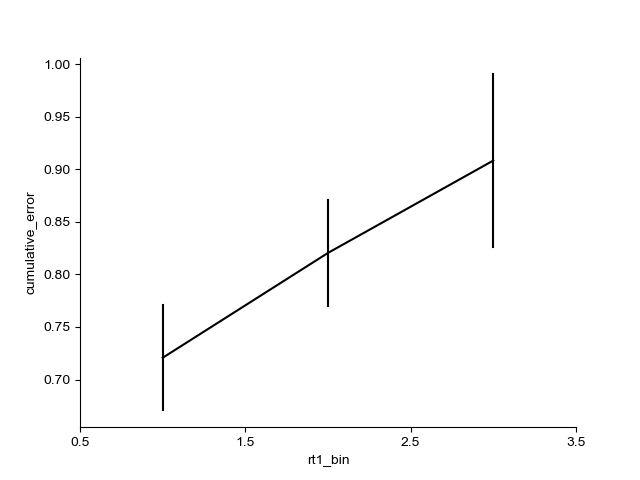

In [25]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='cumulative_error', 
             data = error_sub[error_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of rt1', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_rt.png', dpi=300, bbox_inches='tight')
plt.show()

#### correlation with undoRT/submitRT

In [149]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['undoRT'].mean()))

SpearmanrResult(correlation=0.39315581654348486, pvalue=0.00021603234339970947)


In [150]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.3579021970233877, pvalue=0.0008301893408130178)


In [151]:
print(spearmanr(state_notundo_1undo.groupby(['subjects'])['RT1'].mean() , state_notundo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.5707948996201845, pvalue=1.2638417618044503e-09)


# context RPE

In [43]:

# shift RPE to make it positive
# state_df_1undo['RPE'] = state_df_1undo['RPE'] + 10
print(spearmanr(state_df_1undo.groupby(['subjects'])['cumulative_error'].mean() , state_df_1undo.groupby(['subjects'])['RPE'].mean()))
print(spearmanr(state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RT1_log'].mean() , state_df_1undo[state_df_1undo.error==False].groupby(['subjects'])['RPE'].mean()))

SpearmanrResult(correlation=-0.5781575869149997, pvalue=2.996669199925777e-10)
SpearmanrResult(correlation=-0.18095238095238095, pvalue=0.07306650583637313)


In [69]:
%%R 
model_undo = lme4::glmer(firstUndo ~  1 + avg_numCities_before + cumulative_error + RT1_log + (1 |subjects) + (1|puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + avg_numCities_before + cumulative_error + RT1_log +  
    (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  3048.2   3086.2  -1518.1   3036.2     4107 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.2384 -0.3893 -0.1276  0.0735  9.6533 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.671    2.9447  
 puzzleID (Intercept) 0.659    0.8118  
Number of obs: 4113, groups:  subjects, 100; puzzleID, 46

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.80286    1.71880  -1.049    0.294    
avg_numCities_before -0.12219    0.19425  -0.629    0.529    
cumulative_error      1.45150    0.07802  18.605   <2e-16 ***
RT1_log              -0.17751    0.11737  -1.512    0.130    
---
Signif. codes:  0 

# RT

In [33]:
def organize_data(df, cond, type_):
    index_singleUndo = df.index[cond]
    df1 = df.loc[index_singleUndo, ['subjects', 'puzzleID', 'allMAS','RT', 'undo']]
    df1["N_more"] = df.loc[index_singleUndo-1, 'N_more'].values
    df1["currNumCities"] = df.loc[index_singleUndo-1, 'currNumCities'].values
    df1["severityOfErrors"] = df.loc[index_singleUndo-1, 'severityOfErrors'].values
    df1["cumulative_error"] = df.loc[index_singleUndo-1, 'cumulative_error'].values
    df1["scaled_N_more_bin"] = df.loc[index_singleUndo-1, 'scaled_N_more_bin'].values
    df1['type'] = type_
    return df1

df1 = organize_data(sc_data_choice_level, (sc_data_choice_level['firstUndo'] == 1) &(sc_data_choice_level['lastUndo'] == 1), "singleUndo")
df2 = organize_data(sc_data_choice_level, (sc_data_choice_level['firstUndo'] == 1) &(sc_data_choice_level['lastUndo'] != 1), "seqUndo")
df3 = organize_data(sc_data_choice_level, (sc_data_choice_level['undo'] == 0) & (sc_data_choice_level['RT'] != -1) & (sc_data_choice_level['submit'] == 0), "move")

df_all = pd.concat([df1, df2, df3])

In [18]:
%%R -i df_all,out_dir2
df_all$subjects <- as.factor(df_all[,"subjects"])
df_all$puzzleID <- as.factor(df_all[,"puzzleID"])
df_all$undo <- as.factor(df_all[,"undo"])
df_all$RT <- df_all$RT/1000
df_all$RT_log <- log(df_all$RT)

write.csv(df_all, file = paste0(data_dir, "statsdata_rt.csv"), row.names = F)

### all states

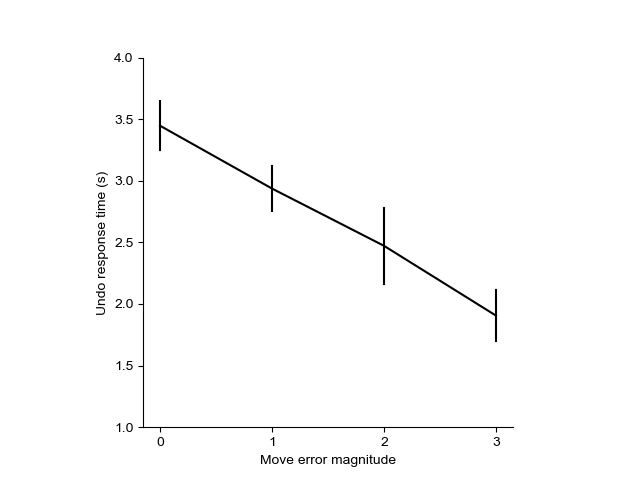

In [21]:
df = df_all[df_all.undo==1].groupby(['subjects','severityOfErrors'])['RT'].mean().reset_index()
count_df = df.groupby(['severityOfErrors'])['RT'].count().reset_index()
df = df.merge(count_df, on = ['severityOfErrors'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='severityOfErrors', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             color = 'k')
# x axis label
axs.set_xticks([0,1,2,3])
axs.set_yticks(np.linspace(1, 4, 7))
axs.set(xlabel='Move error magnitude', ylabel='Undo response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_severityOfError_allstates.png', dpi=300, bbox_inches='tight')

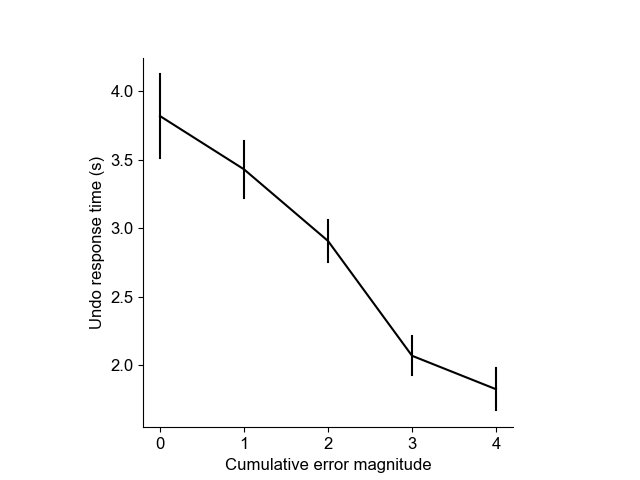

In [77]:
df = df_all[df_all.undo==1].groupby(['subjects','cumulative_error'])['RT'].mean().reset_index()
count_df = df.groupby(['cumulative_error'])['RT'].count().reset_index()
df = df.merge(count_df, on = ['cumulative_error'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='cumulative_error', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             color = 'k')
axs.set(xlabel='Cumulative error magnitude', ylabel='Undo response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_cumulative_error_allstates.png', dpi=300, bbox_inches='tight')

### from non-terminal state: undo/Move

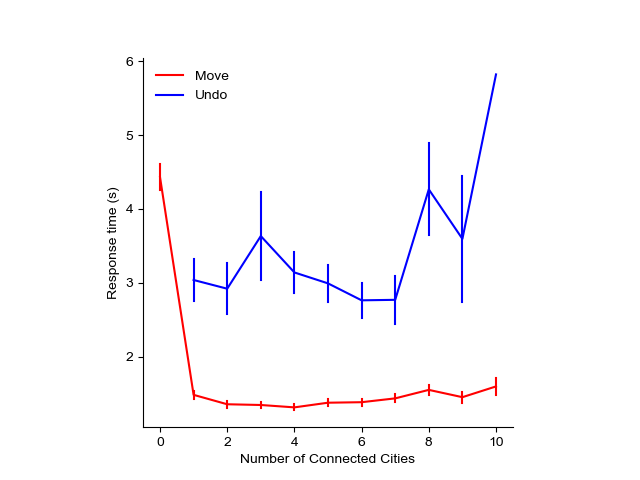

In [34]:
df = df_all[df_all.N_more != 0].groupby(["undo",'subjects','currNumCities'])['RT'].mean().reset_index() #
count_df = df.groupby(["undo",'currNumCities'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'currNumCities'], how = "left", suffixes = ("","_count"))
# df = df[df['RT_count'] > 0]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='currNumCities', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])
# axs.set_xticks(np.arange(0.5, 10.5, 1))
# axs.set_xticklabels(cutoff_nmore[1:].round(2))
plt.legend(labels=['Move','Undo'], loc='upper left')
axs.set(xlabel='Number of Connected Cities', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_currNumCities.png', dpi=300, bbox_inches='tight')

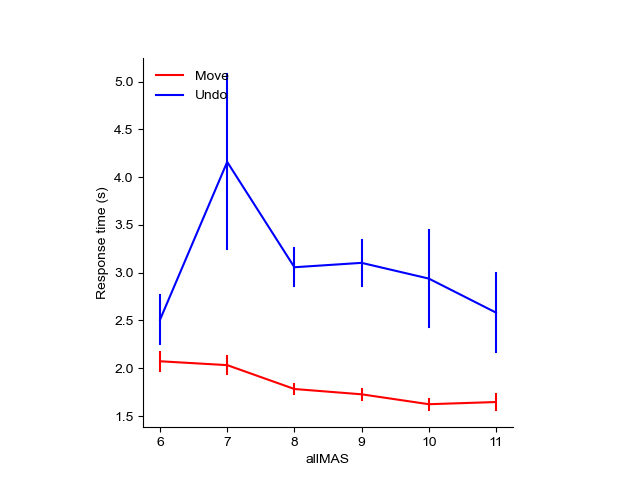

In [37]:
df = df_all[df_all.N_more != 0].groupby(["undo",'subjects','allMAS'])['RT'].mean().reset_index() #
count_df = df.groupby(["undo",'allMAS'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'allMAS'], how = "left", suffixes = ("","_count"))
# df = df[df['RT_count'] > 0]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='allMAS', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])
# axs.set_xticks(np.arange(0.5, 10.5, 1))
# axs.set_xticklabels(cutoff_nmore[1:].round(2))
plt.legend(labels=['Move','Undo'], loc='upper left')
axs.set(xlabel='allMAS', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_allMAS.png', dpi=300, bbox_inches='tight')

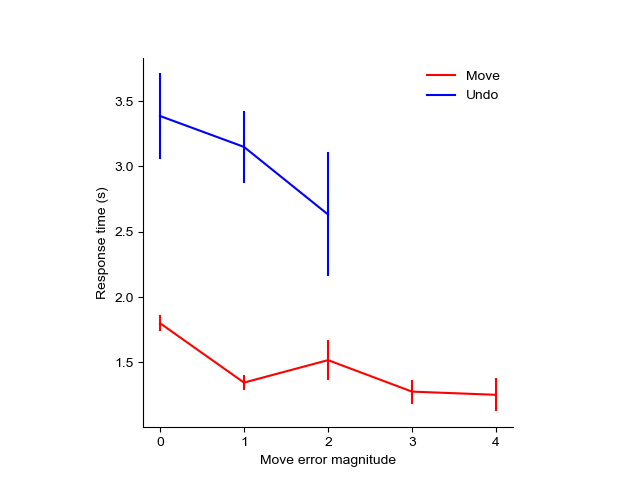

In [53]:
df = df_all[df_all.N_more != 0].groupby(["undo",'subjects','severityOfErrors'])['RT'].mean().reset_index()
count_df = df.groupby(["undo",'severityOfErrors'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'severityOfErrors'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 10]
df['RT'] = df['RT']/1000

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='severityOfErrors', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])
# axs.set_xticks(np.arange(0.5, 10.5, 1))
# axs.set_xticklabels(cutoff_nmore[1:].round(2))
plt.legend(labels=['Move','Undo'], loc='upper right')
axs.set(xlabel='Move error magnitude', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_severityOfError.png', dpi=300, bbox_inches='tight')

### from terminal state: undo/submit

In [65]:
state_undo_1undo = uncertainty_df_process(sc_data_choice_level, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(sc_data_choice_level, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

# remove rows if RPE is nan
state_df_1undo = state_df_1undo.dropna(subset=['RPE'])
temp2, cutoff = pd.cut(state_df_1undo['RPE'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['RPE_bin'] = temp2.astype(int)

In [ ]:

plot_df = state_df_1undo.groupby(['subjects','firstUndo','currNumCities'])['RT'].mean().reset_index()
plot_df['RT'] = plot_df['RT']/1000
count_df = plot_df.groupby(['firstUndo','currNumCities'])['RT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','currNumCities'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['RT_count'] > 20]
 
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='currNumCities', y='RT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Submit','Undo'], loc='upper left')
axs.set(xlabel='Number of Connected Cities', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_currNumCities.png', dpi=300, bbox_inches='tight')

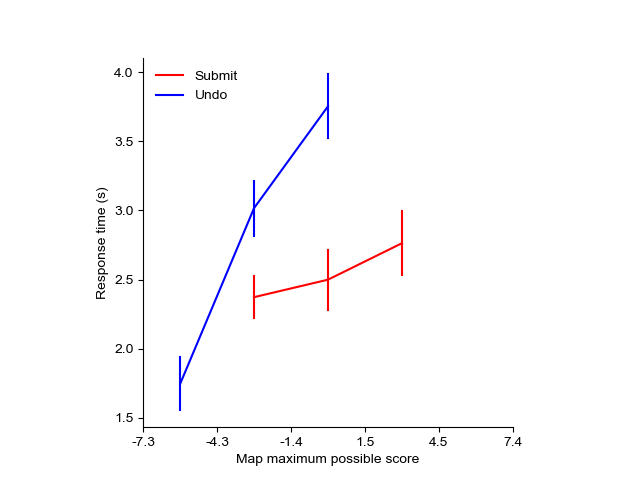

In [68]:
plot_df = state_df_1undo.groupby(['subjects','firstUndo','RPE_bin'])['RT'].mean().reset_index()
plot_df['RT'] = plot_df['RT']/1000
count_df = plot_df.groupby(['firstUndo','RPE_bin'])['RT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','RPE_bin'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['RT_count'] > 20]
 
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='RPE_bin', y='RT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 6.5, 1))
axs.set_xticklabels(cutoff_round)
plt.legend(labels=['Submit','Undo'], loc='upper left')
axs.set(xlabel='Map maximum possible score', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_RPE.png', dpi=300, bbox_inches='tight')

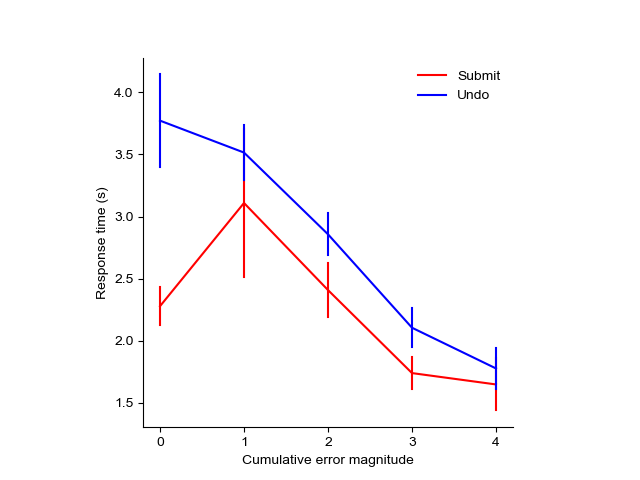

In [44]:
state_undo_1undo = uncertainty_df_process(sc_data_choice_level, f"(firstUndo ==1)", 1)
state_notundo_1undo = uncertainty_df_process(sc_data_choice_level, f"(submit ==1)", 0)
state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
state_df_1undo = state_df_1undo.reset_index(drop=True)

plot_df = state_df_1undo.groupby(['subjects','firstUndo','cumulative_error'])['RT'].mean().reset_index()
plot_df['RT'] = plot_df['RT']/1000
count_df = plot_df.groupby(['firstUndo','cumulative_error'])['RT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','cumulative_error'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['RT_count'] > 10]

# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='cumulative_error', y='RT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Submit','Undo'], loc='upper right')
axs.set(xlabel='Cumulative error magnitude', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_cumulative_error.png', dpi=300, bbox_inches='tight')

In [54]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])
state_df_1undo$puzzleID <- as.factor(state_df_1undo[,"puzzleID"])
state_df_1undo$firstUndo <- as.factor(state_df_1undo[,"firstUndo"])
levels(state_df_1undo$firstUndo) <- c("submit", "undo")
state_df_1undo$RT <- state_df_1undo$RT/1000
state_df_1undo <- state_df_1undo[state_df_1undo$RT <= 20,]
state_df_1undo$RT_log <- log(state_df_1undo$RT)

write.csv(state_df_1undo, file = paste0(data_dir, "statsdata_rt_terminal.csv"), row.names = F)

### sequential undo and single undo

In [83]:
def get_undoRT(index):
    RT = data_choice_level.loc[index,:]
    RT_sub = RT.groupby(['subjects'])['undoRT'].mean()/1000
    RT_sub_sem = sem(RT_sub)
    return [RT_sub,RT_sub_sem]

index_singleUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
RT_singleUndo = get_undoRT(index_singleUndo)

index_firstUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1) &(data_choice_level['lastUndo'] != 1)]
RT_firstUndo = get_undoRT(index_firstUndo)

index_laterUndo = data_choice_level.index[(data_choice_level['firstUndo'] != 1) & (data_choice_level['undo'] == 1)]
RT_laterUndo = get_undoRT(index_laterUndo)

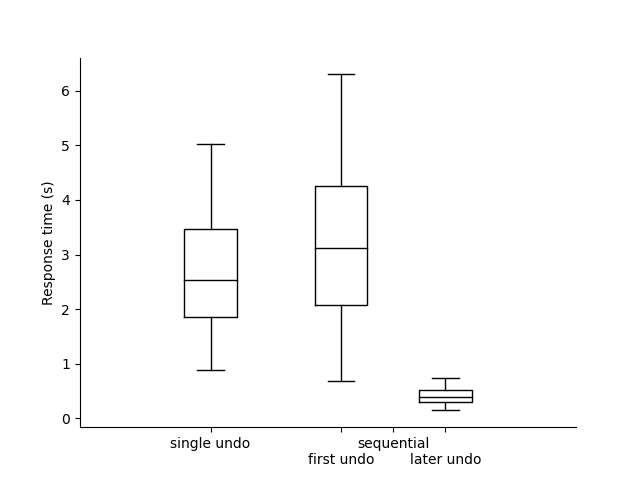

In [84]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot(
    [
        RT_singleUndo[0],
        RT_firstUndo[0],
        RT_laterUndo[0]
    ],
    positions =[0.5,1,1.4],
    widths = 0.2,
    showfliers=False,
    whis = 1,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([0.5,1,1.2,1.4])
axs.set_xticklabels(labels = ['single undo','\nfirst undo','sequential','\nlater undo'])#,fontsize=18
axs.set_ylabel('Response time (s)') #,fontsize=18
plt.show()
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

In [85]:
#--------------------------------------
# run 2-independent-sample t test
stat1, p1 = wilcoxon(np.log(1+RT_firstUndo[0]),np.log(1+RT_laterUndo[0]))
x1, x2 = 1,1.4
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

#--------------------------------------
stat3, p3 = mannwhitneyu(np.log(1+RT_firstUndo[0]),np.log(1+RT_singleUndo[0]))
print(stat3, p3 )
x1, x2 = 0.5,1
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

4000.0 0.01593829273028334


# Undo completion

## Error before and after undo

In [22]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','cum_error_end','error_beginning','error_rate_beginning','error_rate_end','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)
            error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
            error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        error_rate_end = list(df_undoTarget['error_rate'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        cum_error_end_list = []
        error_rate_end_list = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
            cum_error_end_list.append(accu_severity_error[i])
            error_rate_end_list.append(error_rate_end[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                               'cum_error_beginning':cum_error_beginning_list, 'cum_error_end':cum_error_end_list,
                                                               'error_beginning':error_beginning_list, 
                                                               'error_rate_beginning':error_rate_beginning_list,
                                                               'error_rate_end':error_rate_end_list,
                                                               'mas_gain':mas_gain})])


### Barplot

In [28]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])[['cum_error_beginning','cum_error_end']].mean().reset_index()

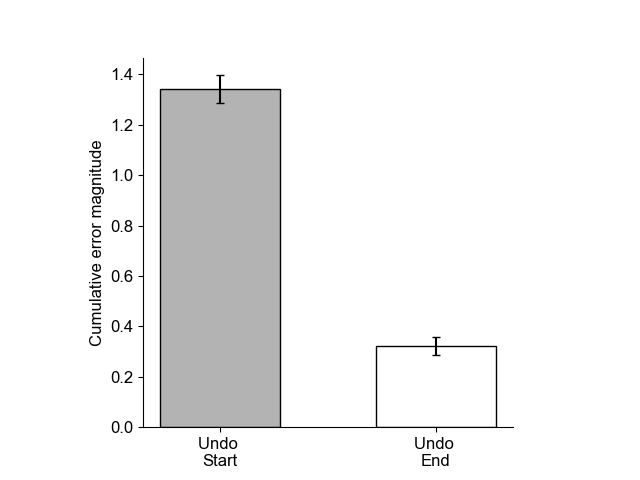

In [31]:
# This uses all undo
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

positions = [1, 1.9]

mean_values = [error_df_sub['cum_error_beginning'].mean(), error_df_sub['cum_error_end'].mean()]
bars = axs.bar(positions,
               mean_values,
               width=0.5,
               color=[(.7, .7, .7), 'w', (.7, .7, .7), 'w'],
               edgecolor='k')

# add standard error
errs = axs.errorbar(positions,
                    mean_values,
                    yerr=[error_df_sub['cum_error_beginning'].sem(), error_df_sub['cum_error_end'].sem()],
                    fmt='none',  # No connecting line
                    capsize=3,  # Cap size for error bar
                    ecolor='k')  # Error bar color

axs.set_ylabel('Cumulative error magnitude')
axs.set_xticks([1,1.9])
axs.set_xticklabels(labels = ['Undo \nStart',
                              'Undo \nEnd'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'error_before_after_undo.png', dpi=300, bbox_inches='tight')

In [32]:
cum_error_before = mas_gain_df.groupby(['subjects'])['cum_error_beginning'].mean()
cum_error_after = mas_gain_df.groupby(['subjects'])['cum_error_end'].mean()

y_offset = 0.1
h = 0.05
stat3, p3 = wilcoxon(cum_error_before, cum_error_after, alternative = 'greater')
print(stat3, p3 )
x1, x2 = positions
y, col = max(mean_values) + y_offset, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'error_before_after_undo.png', dpi=600, bbox_inches='tight')

3916.0 1.8266971276429214e-16


### Error rate

In [ ]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_df_sub

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3460544585.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


,subjects,error_rate_beginning,error_rate_end
0,0,0.171176,0.015152
1,1,0.252847,0.113872
2,2,0.299482,0.055556
3,3,0.547619,0.000000
4,4,0.266478,0.084921
...,...,...,...
85,94,0.800000,0.000000
86,95,0.144901,0.091991
87,96,0.120201,0.011792
88,97,0.436508,0.166667


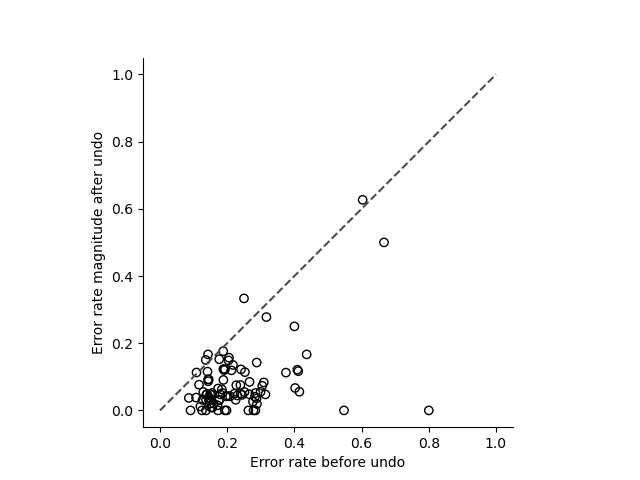

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='error_rate_beginning', y='error_rate_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 1], [0, 1], ls="--", c=".3")
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
# ax1.set_xticks(np.arange(0, 1.5, 1))
# ax1.set_yticks(np.arange(0, 1.5, 1))
ax1.set_xlabel("Error rate before undo")
ax1.set_ylabel("Error rate magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'errorrate_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

## Proportion of different undo result

In [23]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','terminal_beginning','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_nostart,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_nostart,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list, 
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_3["terminal"] = "notstart"

In [24]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID', 'terminal_beginning', 'cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index_copy"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)
                
        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_start,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_start,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_2["terminal"] = "start"

In [25]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T
accu_error_p

category         0                   1                   2
terminal  notstart     start  notstart     start  notstart
subjects                                                  
0         0.222222  0.111111  0.555556  0.000000  0.111111
1         0.043478  0.000000  0.347826  0.173913  0.434783
2         0.033333  0.300000  0.066667  0.533333  0.066667
3         0.000000  0.500000  0.000000  0.500000  0.000000
4         0.000000  0.105263  0.105263  0.473684  0.315789
...            ...       ...       ...       ...       ...
94        0.000000  0.000000  0.000000  1.000000  0.000000
95        0.125000  0.083333  0.166667  0.333333  0.291667
96        0.142857  0.114286  0.257143  0.428571  0.057143
97        0.000000  0.000000  0.333333  0.333333  0.333333
99        0.227273  0.181818  0.045455  0.409091  0.136364

[90 rows x 5 columns]

In [26]:
accu_error = accu_error.merge(single_condition_data[["subjects",'puzzleID','RT1']], on= ["subjects",'puzzleID'], how = "left")

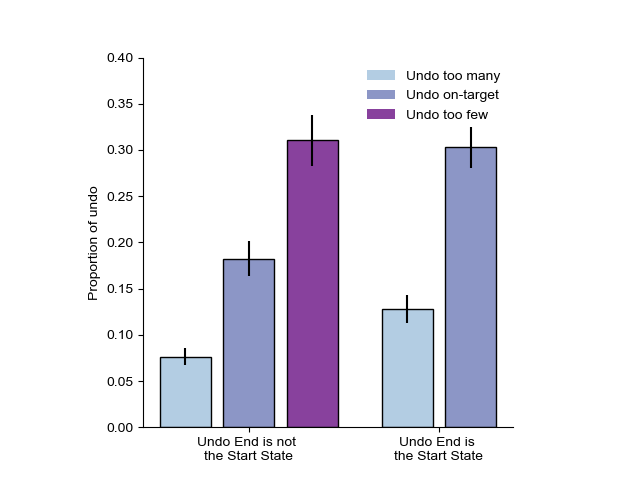

In [65]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo on-target'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo End is not \nthe Start State','Undo End is \nthe Start State'])
plt.ylabel('Proportion of undo')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_completion type.png', dpi=300, bbox_inches='tight')

## what predicts the undo terminal

### sequential or single

In [21]:
accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['sequential_single','terminal_beginning','subjects'])['terminal_number'].mean().reset_index()
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.barplot(x='terminal_beginning', y='terminal_number', 
             data = plot_df,
             hue = 'sequential_single',
             palette = ['red','blue'])

NameError: name 'accu_error' is not defined

### RT1

  rt1_bin  terminal_number
0       1               32
1       2               75
2       3               73
3       4               61
4       5               41


<AxesSubplot:xlabel='rt1_bin', ylabel='terminal_number'>

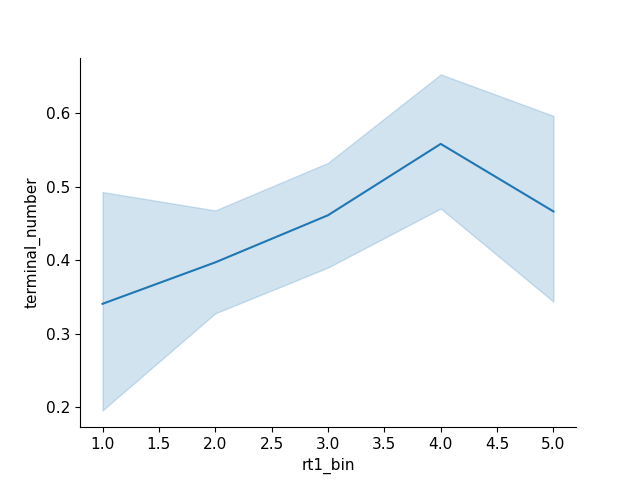

In [230]:
accu_error['RT1_log'] = np.log(1+accu_error.RT1)
temp1, cutoff = pd.cut(accu_error['RT1_log'], bins=[0,1,1.5,2,2.5,5], labels=range(1,6),retbins=True)
accu_error['rt1_bin'] = temp1

accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['rt1_bin','subjects'])['terminal_number'].mean().reset_index()
print(plot_df.groupby(['rt1_bin'])['terminal_number'].count().reset_index())
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='rt1_bin', y='terminal_number', 
             data = plot_df)

### cumulative error magnitude

In [27]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

In [44]:
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    82
3    58
4    31
5     4
6     1
Name: undo_right, dtype: int64

In [45]:
accu_error

,subjects,puzzleID,terminal_beginning,cum_error_beginning,error_beginning,error_rate_beginning,category,sequential_single,terminal,undo_right,undo_too_many,undo_too_few
10,0,28,1,3,0,0.500000,0,False,start,False,True,False
10,1,15,1,3,1,0.500000,1,False,start,True,False,False
14,1,18,1,2,0,0.250000,1,False,start,True,False,False
10,1,30,0,1,0,0.166667,1,False,start,True,False,False
4,1,38,0,2,1,0.666667,1,False,start,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
17,99,17,1,1,0,0.142857,0,False,notstart,False,True,False
3,99,24,0,1,0,0.333333,2,True,notstart,False,False,True
25,99,29,1,1,0,0.125000,0,False,notstart,False,True,False
13,99,31,1,1,0,0.111111,0,False,notstart,False,True,False


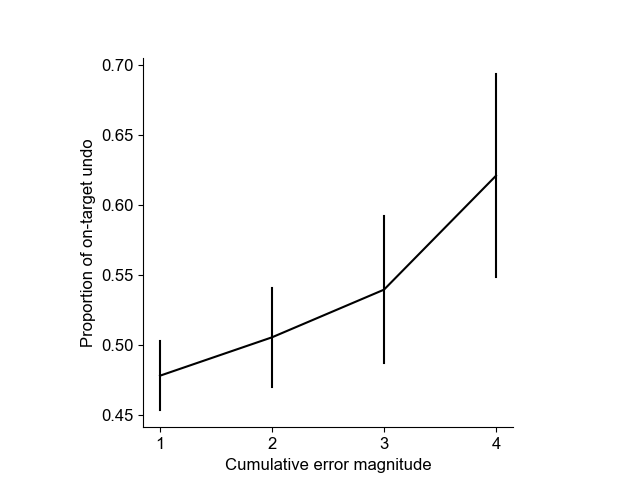

In [48]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_error.png', dpi=300, bbox_inches='tight')

In [29]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$puzzleID <- as.factor(accu_error[,"puzzleID"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, family = binomial(link="logit"))

# save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects) + (1 |  
    puzzleID)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2700.4   2722.9  -1346.2   2692.4     2040 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4173 -0.8422 -0.4943  0.9142  2.4136 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.3405   0.5836  
 puzzleID (Intercept) 0.2841   0.5331  
Number of obs: 2044, groups:  subjects, 90; puzzleID, 46

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.54855    0.15531  -3.532 0.000412 ***
cum_error_beginning  0.28721    0.06496   4.422 9.79e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.645


### error magnitude before undo

In [30]:
undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    86
1    76
2    33
3    14
4     1
6     1
Name: undo_right, dtype: int64

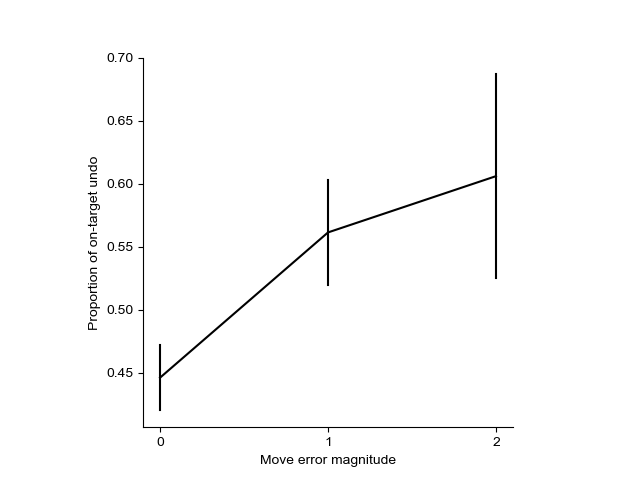

In [68]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Move error magnitude', ylabel='Proportion of on-target undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [31]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)
accu_error$puzzleID <- as.factor(accu_error[,"puzzleID"])

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + (1 |subjects) + (1 | puzzleID),
                                  data = accu_error, 
                                  family = binomial(link="logit"))

# save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + (1 | subjects) + (1 | puzzleID)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2695.3   2717.8  -1343.7   2687.3     2040 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4347 -0.8353 -0.5067  0.9062  2.5517 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.3260   0.571   
 puzzleID (Intercept) 0.2916   0.540   
Number of obs: 2044, groups:  subjects, 90; puzzleID, 46

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.12478    0.11862  -1.052    0.293    
error_beginning  0.25350    0.05254   4.825  1.4e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
errr_bgnnng -0.028


### Error rate

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_rate_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_rate_beginning'])['undo_right'].count()

error_rate_beginning
0.090909    28
0.100000    28
0.111111    66
0.125000    70
0.142857    60
0.166667    54
0.200000    24
0.222222    16
0.250000    69
0.285714    62
0.333333    48
0.375000     6
0.400000    29
0.428571    35
0.500000    57
0.571429     1
0.600000    20
0.666667    19
0.714286     1
0.750000     7
0.800000    14
0.833333     1
1.000000    22
1.250000     1
1.333333     7
1.500000     6
2.000000     1
3.000000     1
Name: undo_right, dtype: int64

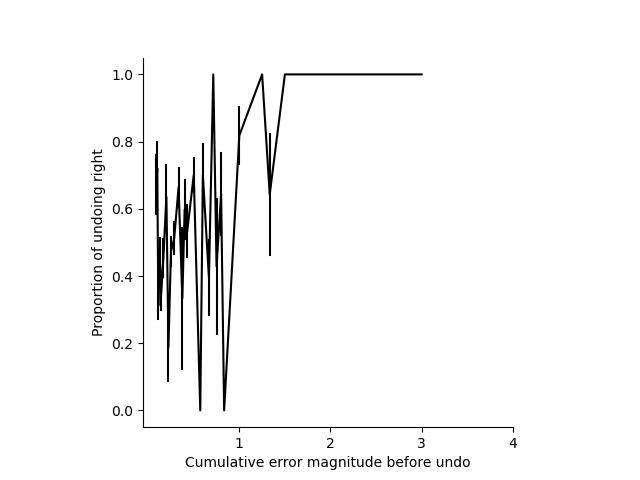

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_rate_beginning', y='undo_right',
                data = undo_right_sub,
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_errorrate.png', dpi=300, bbox_inches='tight')

## Correlations

## Metric 1: proportions

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_right_prop = accu_error.groupby(['subjects'])['undo_right'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_right_prop.index)]

spearmanr(score, undo_right_prop)

SpearmanrResult(correlation=-0.13312064506005297, pvalue=0.21100181575591548)

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_few_prop = accu_error.groupby(['subjects'])['undo_too_few'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_few_prop.index)]

spearmanr(score, undo_few_prop)

SpearmanrResult(correlation=0.1470036625195117, pvalue=0.16677864009093307)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_right_prop.index)]
spearmanr(balanced_accuracy, undo_right_prop)

SpearmanrResult(correlation=-0.033595457200651664, pvalue=0.7532566675233603)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_few_prop.index)]
spearmanr(balanced_accuracy, undo_few_prop)

SpearmanrResult(correlation=-0.06698676011526265, pvalue=0.5304532980708084)

## Metric 2: Error rate change

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, score)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3807902533.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.03115437580352458, pvalue=0.7706722334841731)

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, balanced_accuracy)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/2976432119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.0444307239747956, pvalue=0.6775415110542389)

## Metric 3: MAS gain

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(mas_gain.index)]
spearmanr(mas_gain, balanced_accuracy)

SpearmanrResult(correlation=-0.10919093542725634, pvalue=0.30561654498857593)

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(mas_gain.index)]
spearmanr(mas_gain, score)

SpearmanrResult(correlation=0.25321224856022057, pvalue=0.016040797773219848)